# Section 0 - Package Upload

In [1]:
import pandas as pd
import requests
import numpy as np 
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import brightsky
import json
import math
import statsmodels as sm
import urllib.parse
import xgboost

from itertools import product
from tqdm import tqdm
from skimpy import skim
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timezone
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.stattools import acf
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import itertools
from prophet import Prophet

# Section 1 - Loading the Updated Dataset

In [2]:
# get today's date
today = datetime.today()

# create a datetime object with the desired format
date_string = today.strftime('%Y-%m-%dT%H:%M:%S.%fZ')

# convert the datetime object to UTC timezone
date_obj = datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S.%fZ').replace(tzinfo=timezone.utc)

# print the date in the desired format
print(date_obj.strftime('%Y-%m-%dT%H:%M:%S.%fZ'))

2023-04-24T22:28:29.200400Z


In [3]:
#removed for sharing purposes
SENSOR = ''
TOKEN = ''
#url= f'https://app.odi.clickbar.app/api/sensors/{sensor}/data?filter[measured_at_after]=2022-12-01T00:00:00.000000Z'
headers = {
  'content-type': 'application/json',
  'authorization': f'Bearer {token}'
}
url= f''
end_time_string = "2022-06-01T01:00:00.000000Z"  #date where only the other sensor was active

#end_time = datetime.strptime(end_time_string, '%Y-%m-%dT%H:%M:%S.%fZ').replace(tzinfo=timezone.utc)
parameter_dict = {'filter[measured_at_before]': date_obj}

df = pd.DataFrame()

while str(end_time_string) < str(parameter_dict['filter[measured_at_before]']):
    parameters = urllib.parse.urlencode(parameter_dict)
    get_url = url + parameters
    r = requests.request('GET',url=get_url,headers=headers)
    print(r.status_code)
    data_json = r.json()
    df_update = pd.json_normalize(data_json)
    df = pd.concat([df, df_update], ignore_index=True)    
    parameter_dict['filter[measured_at_before]'] = data_json[-1]['measured_at']

200
200
200
200
200


In [4]:
# filter for the sensor under study
df = df[df['sensor_device_id'] == '0004A30B00EF6918'] 
df.head(1)

,id,temperature,orp,ph,do,ec,battery,sensor_device_id,measured_at,unix_time,created_at,updated_at
1,4cee0785-addd-4f68-a780-c9c8cda4b232,16.2,5.83,8.34,63.7,1555,100,0004A30B00EF6918,2023-04-24T19:54:49.000000Z,1682366088514,2023-04-24T20:00:12.000000Z,2023-04-24T20:00:12.000000Z


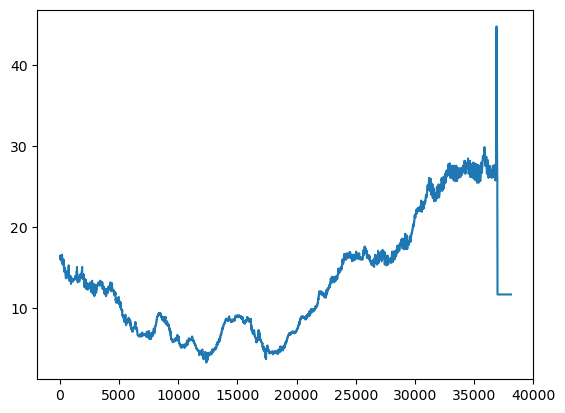

In [5]:
plt.plot(df['temperature'])

In [6]:
df['measured_at'] = pd.to_datetime(df['measured_at'])
# extract year, month, day, and hour
df['year'] = df['measured_at'].dt.year
df['month'] = df['measured_at'].dt.month
df['day'] = df['measured_at'].dt.day
df['hour'] = df['measured_at'].dt.hour
df['minutes'] = df['measured_at'].dt.minute
df['seconds'] = df['measured_at'].dt.second

In [7]:
df.set_index('measured_at')

,id,temperature,orp,ph,do,ec,battery,sensor_device_id,unix_time,created_at,updated_at,year,month,day,hour,minutes,seconds
measured_at,,,,,,,,,,,,,,,,,
2023-04-24 19:54:49+00:00,4cee0785-addd-4f68-a780-c9c8cda4b232,16.2,5.83,8.34,63.7,1555,100,0004A30B00EF6918,1682366088514,2023-04-24T20:00:12.000000Z,2023-04-24T20:00:12.000000Z,2023,4,24,19,54,49
2023-04-24 19:34:26+00:00,70ad32b0-f712-450a-9d37-6dbcc9872d4c,16.2,6.07,8.36,64.2,1557,100,0004A30B00EF6918,1682364865486,2023-04-24T19:45:09.000000Z,2023-04-24T19:45:09.000000Z,2023,4,24,19,34,26
2023-04-24 19:14:03+00:00,1e949f0f-c97e-4857-91aa-43a1f4144ce5,16.2,6.02,8.30,63.7,1557,100,0004A30B00EF6918,1682363642218,2023-04-24T19:15:09.000000Z,2023-04-24T19:15:09.000000Z,2023,4,24,19,14,3
2023-04-24 18:53:32+00:00,39658037-88c2-48f3-8942-b6b130ab35e3,16.3,5.88,8.30,64.3,1560,100,0004A30B00EF6918,1682362411470,2023-04-24T19:00:13.000000Z,2023-04-24T19:00:13.000000Z,2023,4,24,18,53,32
2023-04-24 18:33:09+00:00,11f93134-6149-4605-b387-474d51458d94,16.3,6.37,8.28,62.4,1562,100,0004A30B00EF6918,1682361188462,2023-04-24T18:45:07.000000Z,2023-04-24T18:45:07.000000Z,2023,4,24,18,33,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-19 06:24:23+00:00,b1481ed9-aaab-4681-9870-008affaa5ae1,11.7,0.44,652.76,100.0,1,93,0004A30B00EF6918,1658211863706,2022-08-02T06:45:17.000000Z,2022-08-02T06:45:17.000000Z,2022,7,19,6,24,23
2022-07-19 06:04:00+00:00,bdc69a8d-925e-421b-9617-a353bc6b7d7e,11.7,0.44,652.78,100.0,1,93,0004A30B00EF6918,1658210640721,2022-08-02T06:45:17.000000Z,2022-08-02T06:45:17.000000Z,2022,7,19,6,4,0
2022-07-19 05:43:37+00:00,d32af223-d59a-4d97-9ee1-1d69d924341b,11.7,0.44,652.79,100.0,1,93,0004A30B00EF6918,1658209417717,2022-08-02T06:45:17.000000Z,2022-08-02T06:45:17.000000Z,2022,7,19,5,43,37


In [8]:
df.drop(columns=['sensor_device_id','unix_time','created_at','updated_at'], inplace=True)

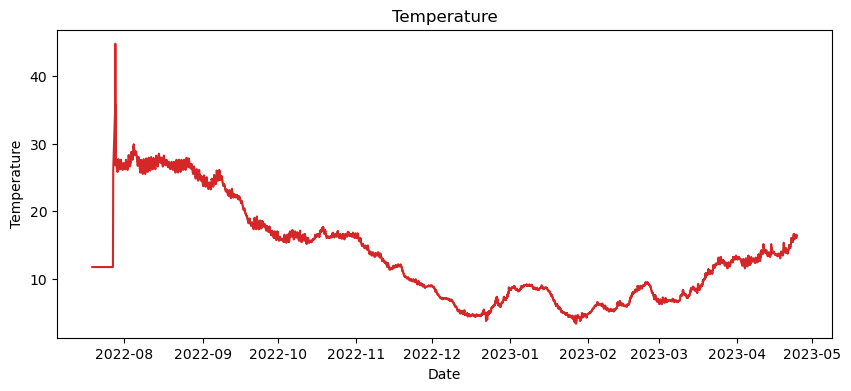

In [9]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Temperature', dpi=100):
    plt.figure(figsize=(10,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df['measured_at'], y=df['temperature'], title='Temperature')

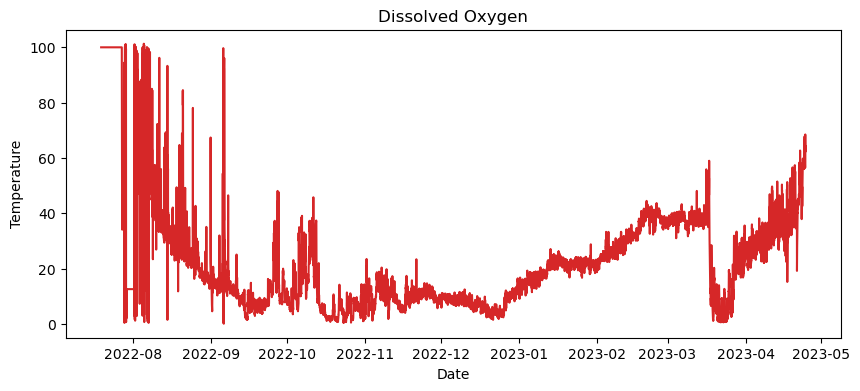

In [10]:
plot_df(df, x=df['measured_at'], y=df['do'], title='Dissolved Oxygen')

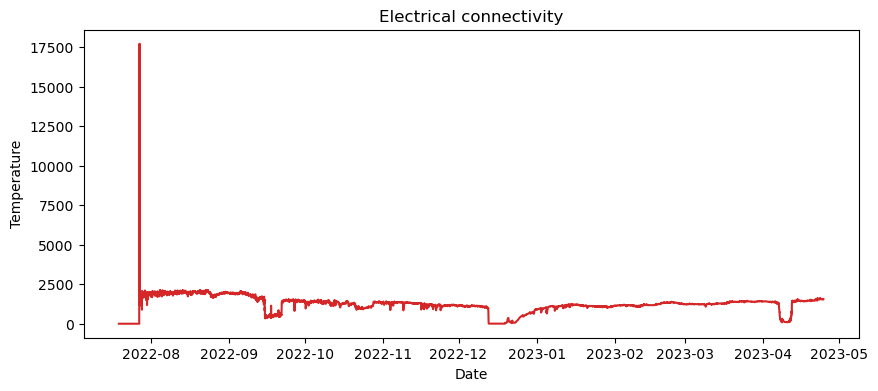

In [11]:
plot_df(df, x=df['measured_at'], y=df['ec'], title='Electrical connectivity')

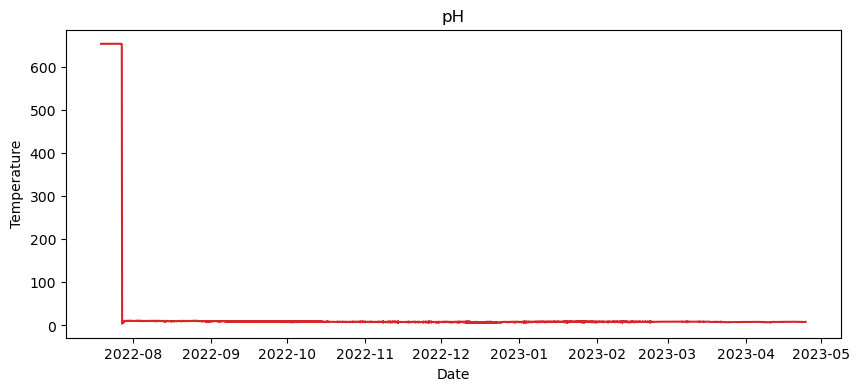

In [12]:
plot_df(df, x=df['measured_at'], y=df['ph'], title='pH')

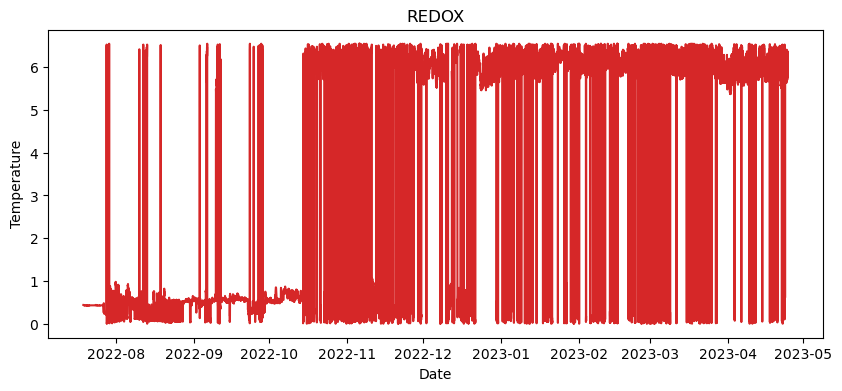

In [13]:
plot_df(df, x=df['measured_at'], y=df['orp'], title='REDOX')

In [14]:
df = df[df['measured_at'] > pd.Timestamp('2022-08-01', tz='UTC')]

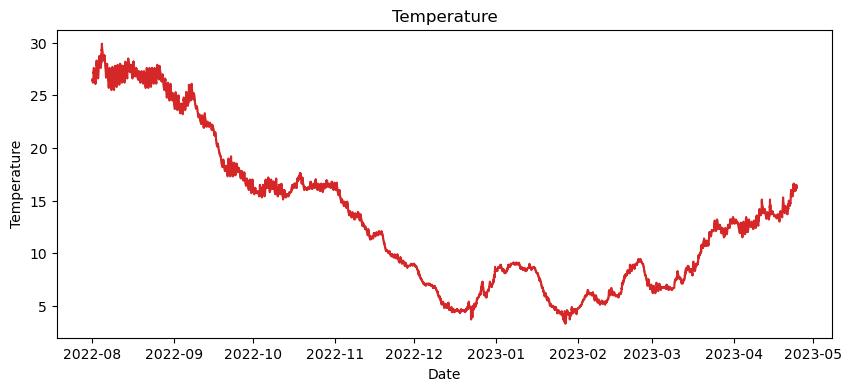

In [15]:
plot_df(df, x=df['measured_at'], y=df['temperature'], title='Temperature')

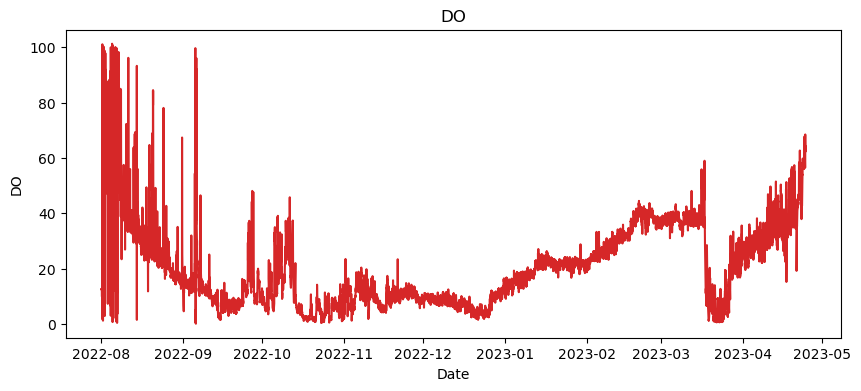

In [16]:
plot_df(df, x=df['measured_at'], y=df['do'], title='DO', ylabel='DO')

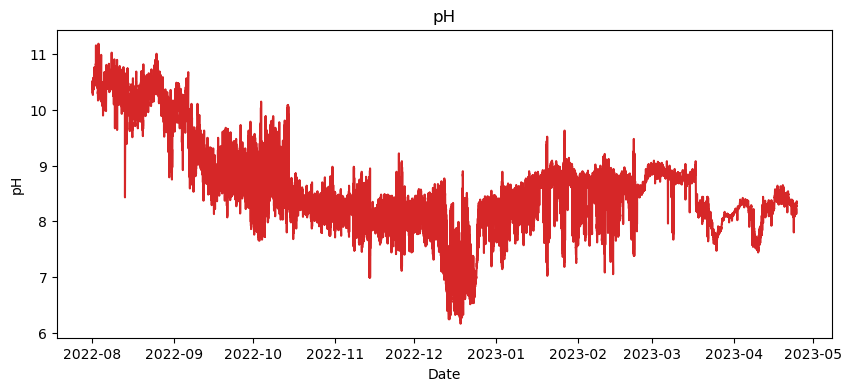

In [17]:
plot_df(df, x=df['measured_at'], y=df['ph'], title='pH', ylabel='pH')

In [18]:
# in case of null values fill the thing with previous one
# no missing value
df.loc[:].fillna(method='ffill', inplace=True)

### Stationarity

In [19]:
temperature = df[['temperature','measured_at']]

In [20]:
temperature.set_index('measured_at')
del temperature['measured_at']
rolling_mean = temperature.rolling(window=24).mean()
rolling_std = temperature.rolling(window=24).std()

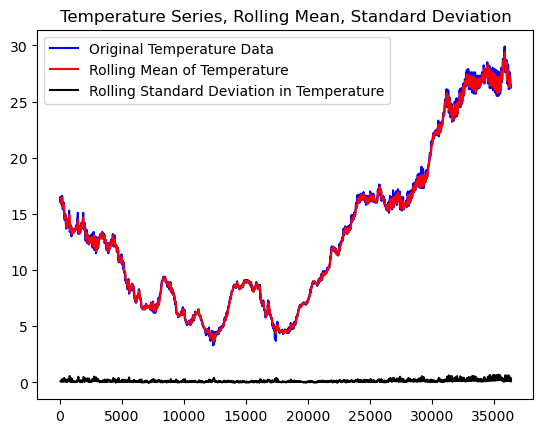

In [21]:
plt.plot(temperature, color="blue",label="Original Temperature Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean of Temperature")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in Temperature")
plt.title("Temperature Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

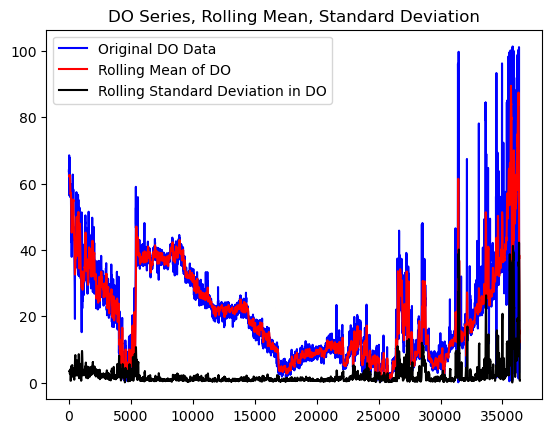

In [22]:
do = df[['do','measured_at']]
do.set_index('measured_at')
del do['measured_at']
rolling_mean = do.rolling(window=24).mean()
rolling_std = do.rolling(window=24).std()
plt.plot(do, color="blue",label="Original DO Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean of DO")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in DO")
plt.title("DO Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

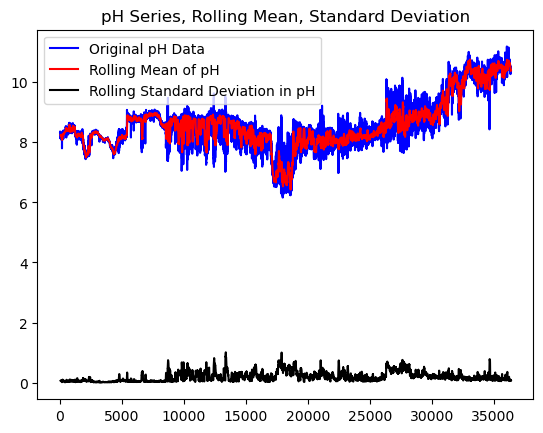

In [23]:
ph = df[['ph','measured_at']]
ph.set_index('measured_at')
del ph['measured_at']
rolling_mean = ph.rolling(window=24).mean()
rolling_std = ph.rolling(window=24).std()
plt.plot(ph, color="blue",label="Original pH Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean of pH")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in pH")
plt.title("pH Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

In [24]:
adft = adfuller(temperature,autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
output_df

,Values,Metric
0,1.850559,Test Statistics
1,0.998444,p-value
2,45.000000,No. of lags used
3,18142.000000,Number of observations used
4,-3.430711,critical value (1%)
5,-2.861699,critical value (5%)
6,-2.566855,critical value (10%)


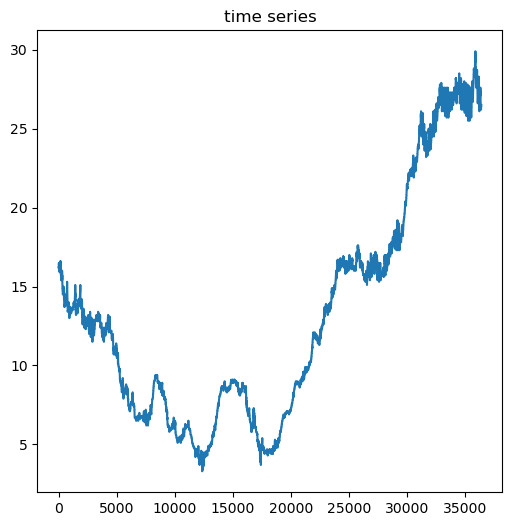

In [25]:
series = temperature.values
temperature.plot(figsize=(6,6), legend=None, title='time series');

In [26]:
autocorrelation_lag1 = temperature['temperature'].autocorr(lag=1)
print("One Lag:   ", autocorrelation_lag1)
autocorrelation_lag3 = temperature['temperature'].autocorr(lag=3)
print("Three Lag: ", autocorrelation_lag3)
autocorrelation_lag3 = temperature['temperature'].autocorr(lag=6)
print("Six Lag: ", autocorrelation_lag3)
autocorrelation_lag3 = temperature['temperature'].autocorr(lag=9)
print("Nine Lag: ", autocorrelation_lag3)

One Lag:    0.9999505904904561
Three Lag:  0.9998579623496126
Six Lag:  0.9996850608168437
Nine Lag:  0.9994337387704744


In [27]:
adft = adfuller(do,autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
output_df
# DO is stationary :)! no change there necessary

,Values,Metric
0,-5.295999,Test Statistics
1,0.000006,p-value
2,45.000000,No. of lags used
3,18142.000000,Number of observations used
4,-3.430711,critical value (1%)
5,-2.861699,critical value (5%)
6,-2.566855,critical value (10%)


In [28]:
autocorrelation_lag1 = do['do'].autocorr(lag=1)
print("One Lag:   ", autocorrelation_lag1)
autocorrelation_lag3 = do['do'].autocorr(lag=3)
print("Three Lag: ", autocorrelation_lag3)
autocorrelation_lag3 = do['do'].autocorr(lag=6)
print("Six Lag: ", autocorrelation_lag3)
autocorrelation_lag3 = do['do'].autocorr(lag=9)
print("Nine Lag: ", autocorrelation_lag3)

One Lag:    0.9355830035612397
Three Lag:  0.910737816861701
Six Lag:  0.8818140643097148
Nine Lag:  0.8704371436601069


In [29]:
adft = adfuller(ph,autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
output_df # non-stationary

,Values,Metric
0,-2.684264,Test Statistics
1,0.076801,p-value
2,45.000000,No. of lags used
3,18142.000000,Number of observations used
4,-3.430711,critical value (1%)
5,-2.861699,critical value (5%)
6,-2.566855,critical value (10%)


In [30]:
autocorrelation_lag1 = ph['ph'].autocorr(lag=1)
print("One Lag:   ", autocorrelation_lag1)
autocorrelation_lag3 = ph['ph'].autocorr(lag=3)
print("Three Lag: ", autocorrelation_lag3)
autocorrelation_lag3 = ph['ph'].autocorr(lag=6)
print("Six Lag: ", autocorrelation_lag3)
autocorrelation_lag3 = ph['ph'].autocorr(lag=9)
print("Nine Lag: ", autocorrelation_lag3)

One Lag:    0.931804512762973
Three Lag:  0.9252578958765004
Six Lag:  0.9126132905608388
Nine Lag:  0.9021932868183856


### Changing towards stationary data

In [31]:
df['measured_at'] = df['measured_at'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d %H:%M:%S'))
df['time']=df['measured_at']
df.set_index('time', inplace=True)
df.index = pd.to_datetime(df.index)
df_hourly = df.copy()
df_hourly = df.resample('H').mean()
df_hourly= df_hourly.sort_index()

In [32]:
df_daily = df.copy()
df_daily = df_daily.resample('d').mean()
df_daily = df_daily.sort_index()
df_daily

,temperature,orp,ph,do,ec,battery,year,month,day,hour,minutes,seconds
time,,,,,,,,,,,,
2022-08-01,26.732857,0.519000,10.509000,41.154286,1874.600000,99.942857,2022.0,8.0,1.0,11.485714,28.028571,31.385714
2022-08-02,27.047143,0.370143,10.636000,74.200000,1922.142857,99.814286,2022.0,8.0,2.0,11.585714,29.971429,28.771429
2022-08-03,27.661429,0.232286,10.580857,54.357143,1877.157143,99.657143,2022.0,8.0,3.0,11.500000,29.900000,29.471429
2022-08-04,28.601449,0.200725,10.367971,56.614493,1922.362319,99.550725,2022.0,8.0,4.0,11.594203,28.724638,29.246377
2022-08-05,28.419118,0.384559,10.358676,36.816176,1943.794118,99.470588,2022.0,8.0,5.0,11.529412,31.014706,28.970588
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-20,14.152857,5.593857,8.405000,42.634286,1475.342857,100.000000,2023.0,4.0,20.0,11.585714,27.700000,29.700000
2023-04-21,14.200000,6.069859,8.414225,38.136620,1490.647887,99.971831,2023.0,4.0,21.0,11.507042,30.112676,29.535211
2023-04-22,15.177143,5.696286,8.311143,51.102857,1535.014286,99.871429,2023.0,4.0,22.0,11.471429,29.985714,28.557143


In [33]:
# check for stationarity
df_hourly['temperature_new'] = df_hourly['temperature']
result = adfuller(df_hourly['temperature'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

differencing_count = 0
if result[1] > 0.05:
    # the data is nonstationary -> difference it 
    diff = df_hourly['temperature_new'].diff(24).dropna()
    result = adfuller(diff)
    print('After differencing:')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    differencing_count +=1
    
    # do differencing until p-value drops
    while result[1] > 0.05:
        diff = diff.diff(24).dropna()
        result = adfuller(diff)
        print('After differencing:')
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
        differencing_count =+1
    df_temperature = diff

ADF Statistic: -1.9920482087091496
p-value: 0.29007052979856884
After differencing:
ADF Statistic: -8.815255117640389
p-value: 1.9421512780700354e-14


In [34]:
# check for stationarity
df_daily['temperature_new'] = df_daily['temperature']
result = adfuller(df_daily['temperature'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

differencing_count = 0
if result[1] > 0.05:
    # the data is nonstationary -> difference it 
    diff = df_daily['temperature_new'].diff(24).dropna()
    result = adfuller(diff)
    print('After differencing:')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    differencing_count +=1
    
    # do differencing until p-value drops
    while result[1] > 0.05:
        diff = diff.diff(24).dropna()
        result = adfuller(diff)
        print('After differencing:')
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
        differencing_count =+1
    df_daily['temperature_new'] = diff


ADF Statistic: -1.8672129706170695
p-value: 0.34763881202645114
After differencing:
ADF Statistic: -2.0789753860289686
p-value: 0.25305230192603134
After differencing:
ADF Statistic: -3.961170210975729
p-value: 0.0016280549222519659


In [35]:
df_hourly['ph_new'] = df_hourly['ph']
result = adfuller(df_hourly['ph'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] > 0.05:
    # the data is nonstationary -> difference it 
    diff = df_hourly['ph_new'].diff(24).dropna()
    result = adfuller(diff)
    print('After differencing:')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    
    # do differencing until p-value drops
    while result[1] > 0.05:
        diff = diff.diff(24).dropna()
        result = adfuller(diff)
        print('After differencing:')
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
    df_hourly['ph_new'] = diff

ADF Statistic: -2.9894692686397306
p-value: 0.035889610045514386


In [36]:
df_daily['ph_new'] = df_daily['ph']
result = adfuller(df_daily['ph'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] > 0.05:
    # the data is nonstationary -> difference it 
    diff = df_daily['ph_new'].diff(24).dropna()
    result = adfuller(diff)
    print('After differencing:')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    
    # do differencing until p-value drops
    while result[1] > 0.05:
        diff = diff.diff(24).dropna()
        result = adfuller(diff)
        print('After differencing:')
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
    df_ph = diff

ADF Statistic: -2.546004893704521
p-value: 0.10467818779832105
After differencing:
ADF Statistic: -3.0651486518455564
p-value: 0.029242175108687693


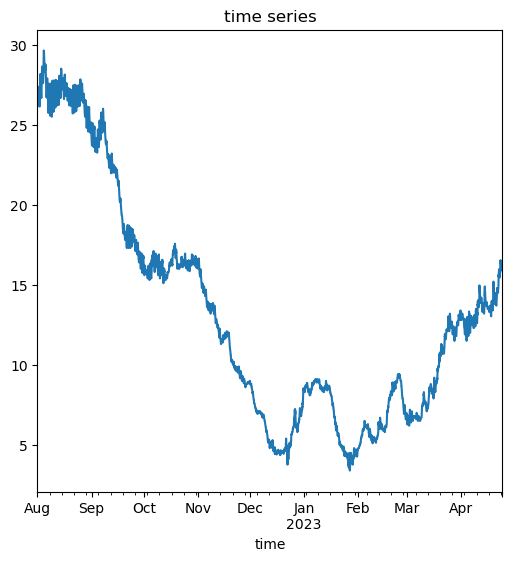

In [37]:
series = df_hourly['temperature_new'].values
df_hourly['temperature_new'].plot(figsize=(6,6), legend=None, title='time series');

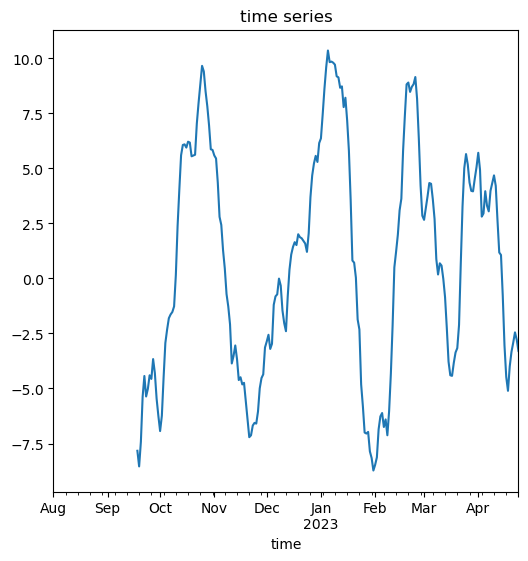

In [38]:
series = df_daily['temperature_new'].values
df_daily['temperature_new'].plot(figsize=(6,6), legend=None, title='time series');

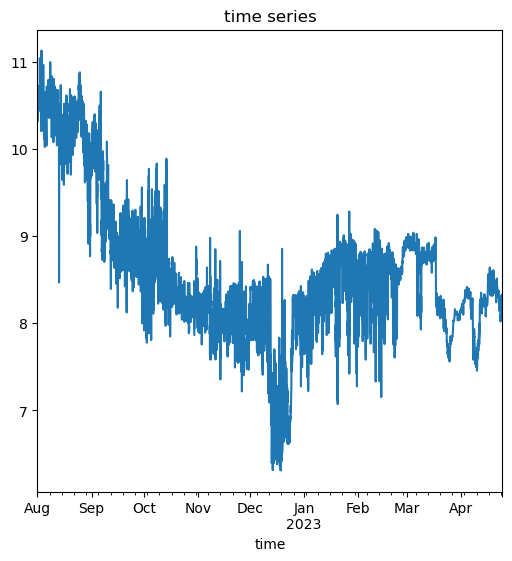

In [39]:
series = df_hourly['ph_new'].values
df_hourly['ph_new'].plot(figsize=(6,6), legend=None, title='time series');

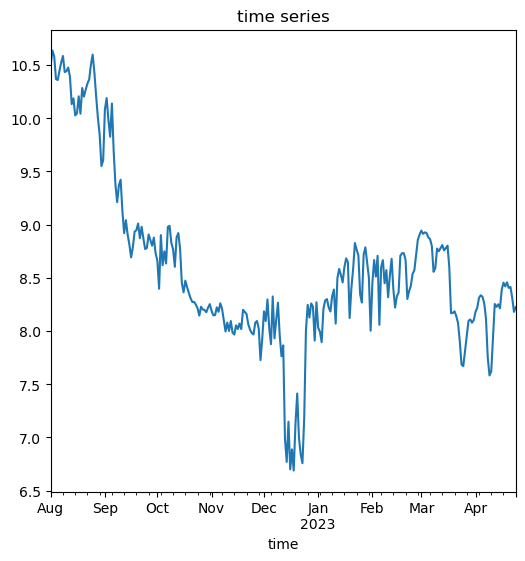

In [40]:
series = df_daily['ph_new'].values
df_daily['ph_new'].plot(figsize=(6,6), legend=None, title='time series');

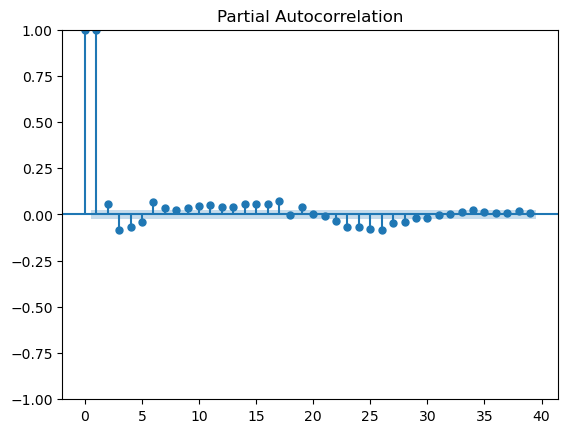

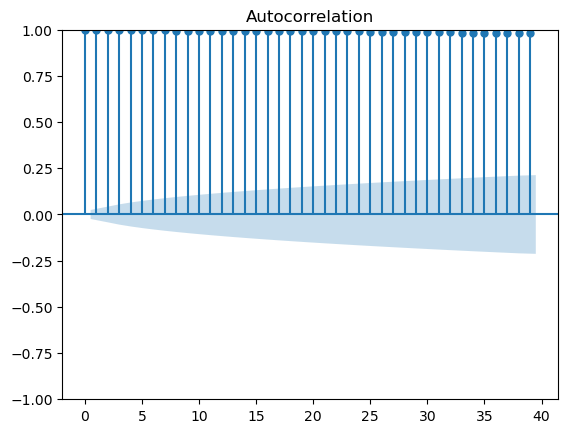

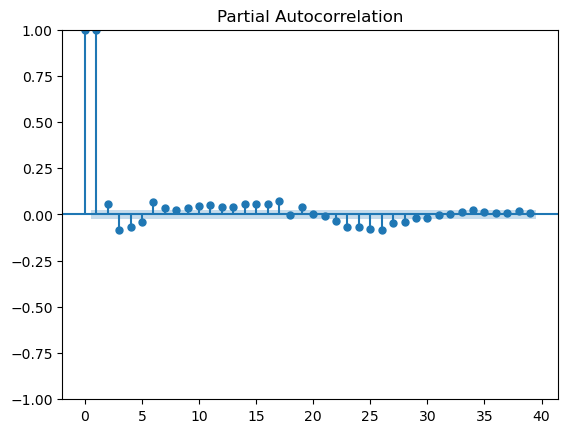

In [41]:
# autocorrelation
mean = np.mean(df_hourly['temperature_new'])
df_1 = df_hourly.fillna(mean)
#do autocorrelation/partial autocorrelation
plot_acf(df_1['temperature_new'])
plot_pacf(df_1['temperature_new'])

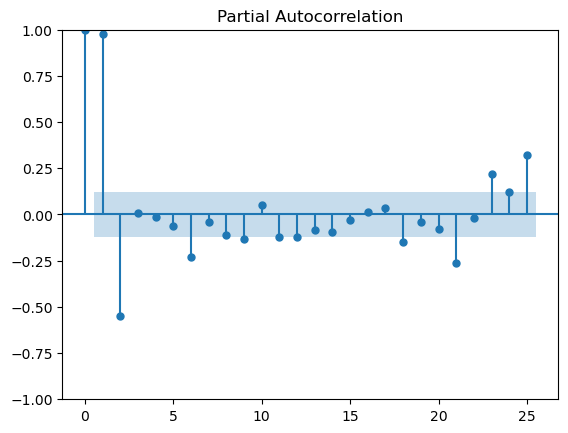

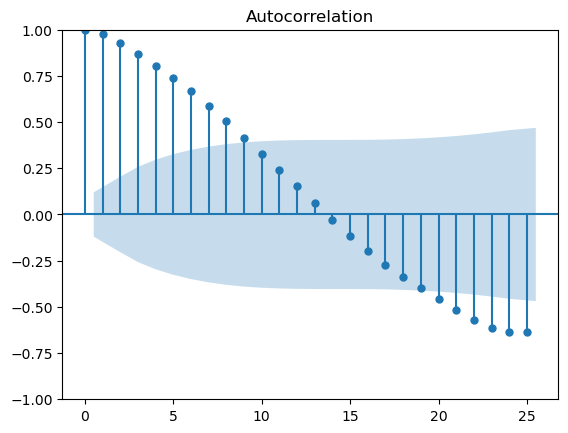

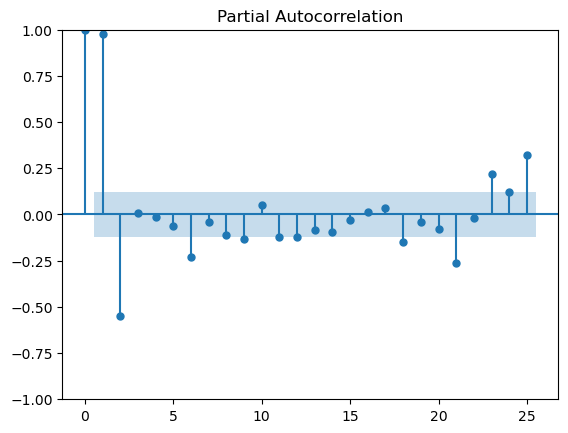

In [42]:
# autocorrelation
mean = np.mean(df_daily['temperature_new'])
df_1 = df_daily.fillna(mean)
#do autocorrelation/partial autocorrelation
plot_acf(df_1['temperature_new'])
plot_pacf(df_1['temperature_new'])

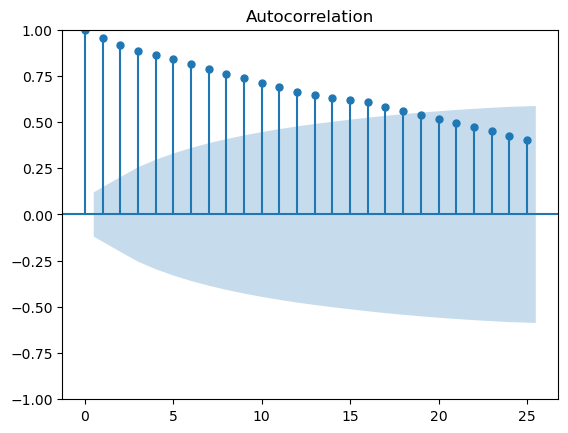

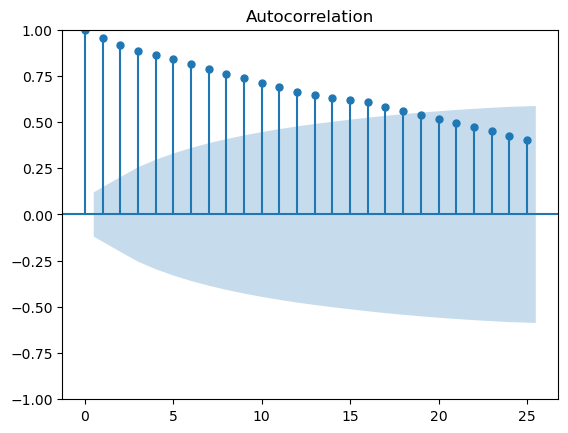

In [43]:
plot_acf(df_1['ph_new'])

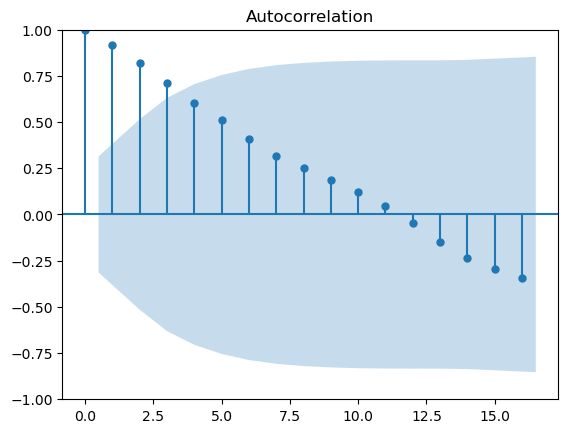

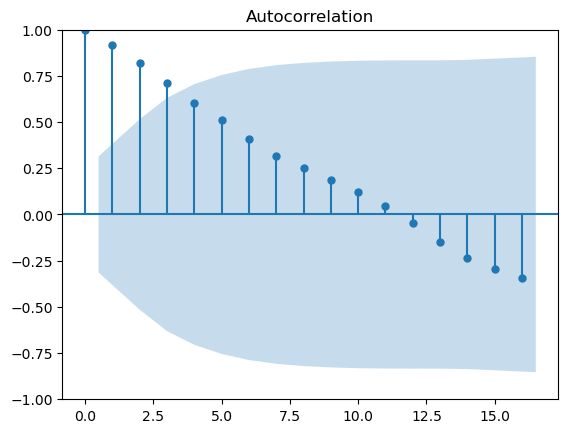

In [44]:
df_w_resampled = df_hourly.copy().resample('W').mean()
df_w_resampled.dropna(inplace=True)
plot_acf(df_w_resampled['temperature_new'])

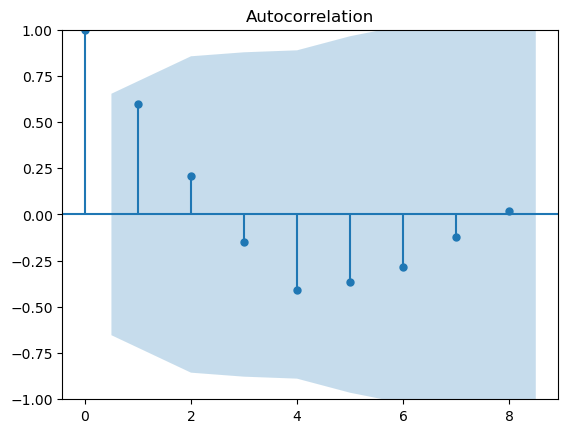

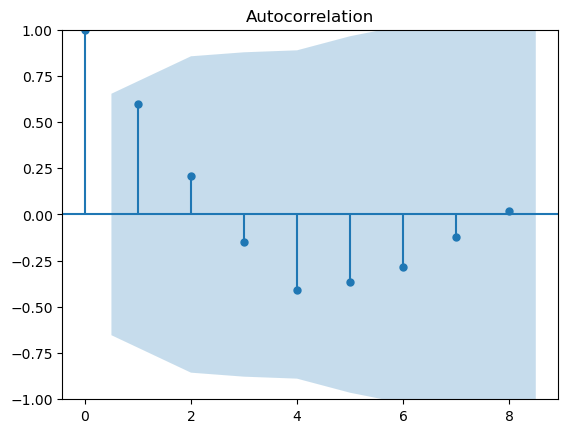

In [45]:
df_m_resampled = df_hourly.copy().resample('M').mean()
df_m_resampled.dropna(inplace=True)
plot_acf(df_m_resampled['temperature_new'])

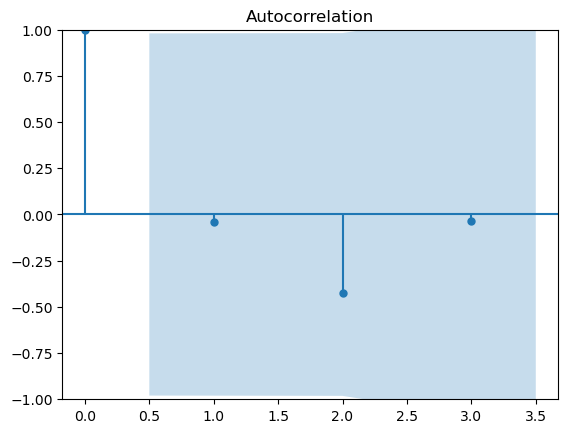

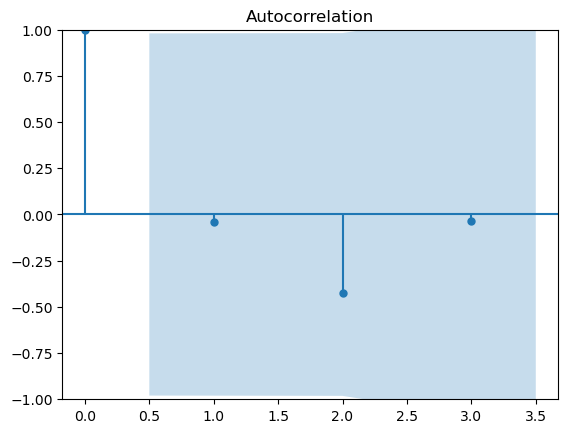

In [46]:
df_q_resampled = df_hourly.copy().resample('Q').mean()
df_q_resampled.dropna(inplace=True)
plot_acf(df_q_resampled['temperature_new'])

In [47]:
autocorrelation_lag1 = df_hourly['temperature_new'].autocorr(lag=1)
print("One Lags:   ", autocorrelation_lag1)
autocorrelation_lag3 = df_hourly['temperature_new'].autocorr(lag=3)
print("Three Lags: ", autocorrelation_lag3)
autocorrelation_lag6 = df_hourly['temperature_new'].autocorr(lag=6)
print("Six Lags: ", autocorrelation_lag3)
autocorrelation_lag9 = df_hourly['temperature_new'].autocorr(lag=9)
print("Nine Lags: ", autocorrelation_lag9)

One Lags:    0.9999041230451394
Three Lags:  0.9995114226499616
Six Lags:  0.9995114226499616
Nine Lags:  0.9977297878131239


In [48]:
autocorrelation_lag1 = df_hourly['ph_new'].autocorr(lag=1)
print("One Lag:   ", autocorrelation_lag1)
autocorrelation_lag3 = df_hourly['ph_new'].autocorr(lag=3)
print("Three Lag: ", autocorrelation_lag3)
autocorrelation_lag3 = df_hourly['ph_new'].autocorr(lag=6)
print("Six Lag: ", autocorrelation_lag3)
autocorrelation_lag3 = df_hourly['ph_new'].autocorr(lag=9)
print("Nine Lag: ", autocorrelation_lag3)

One Lag:    0.9641063552156178
Three Lag:  0.9420187831911043
Six Lag:  0.9210468426225916
Nine Lag:  0.9059987546899355


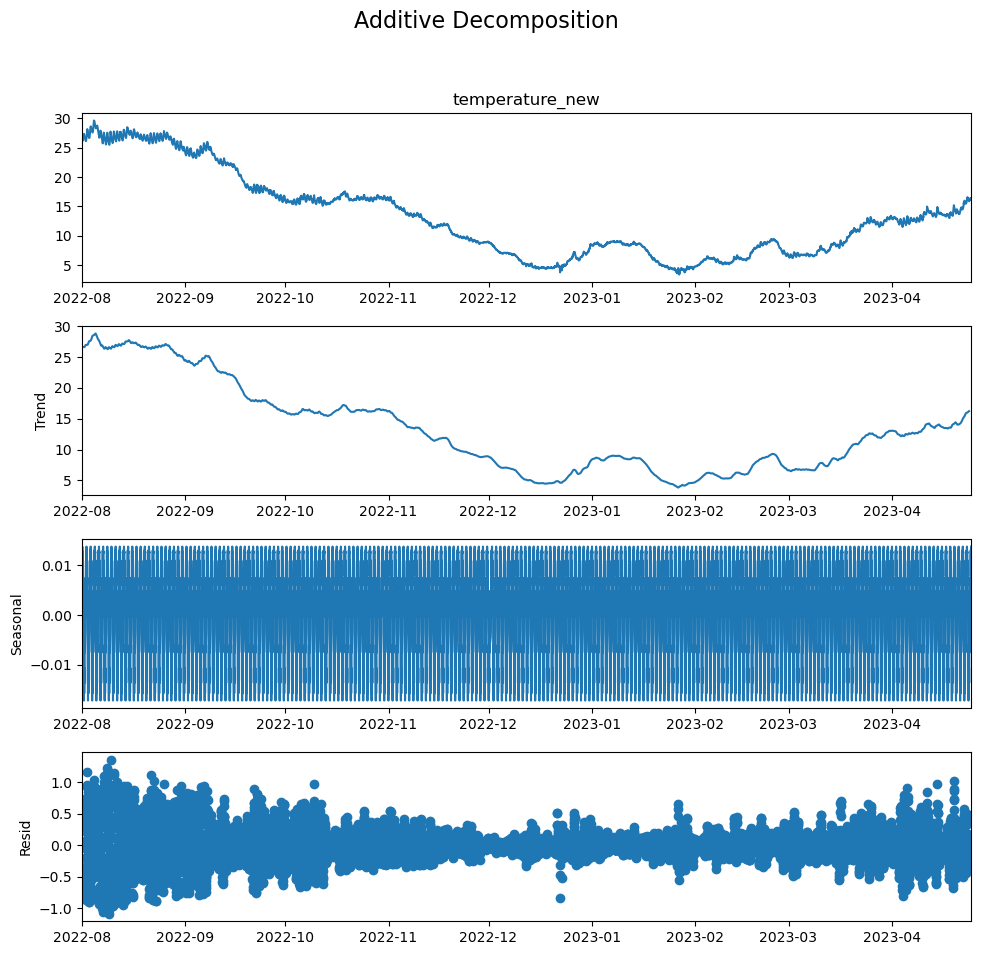

In [49]:
# Additive Decomposition
additive_decomposition = seasonal_decompose(df_hourly['temperature_new'].dropna(), model='additive', period=30)
# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

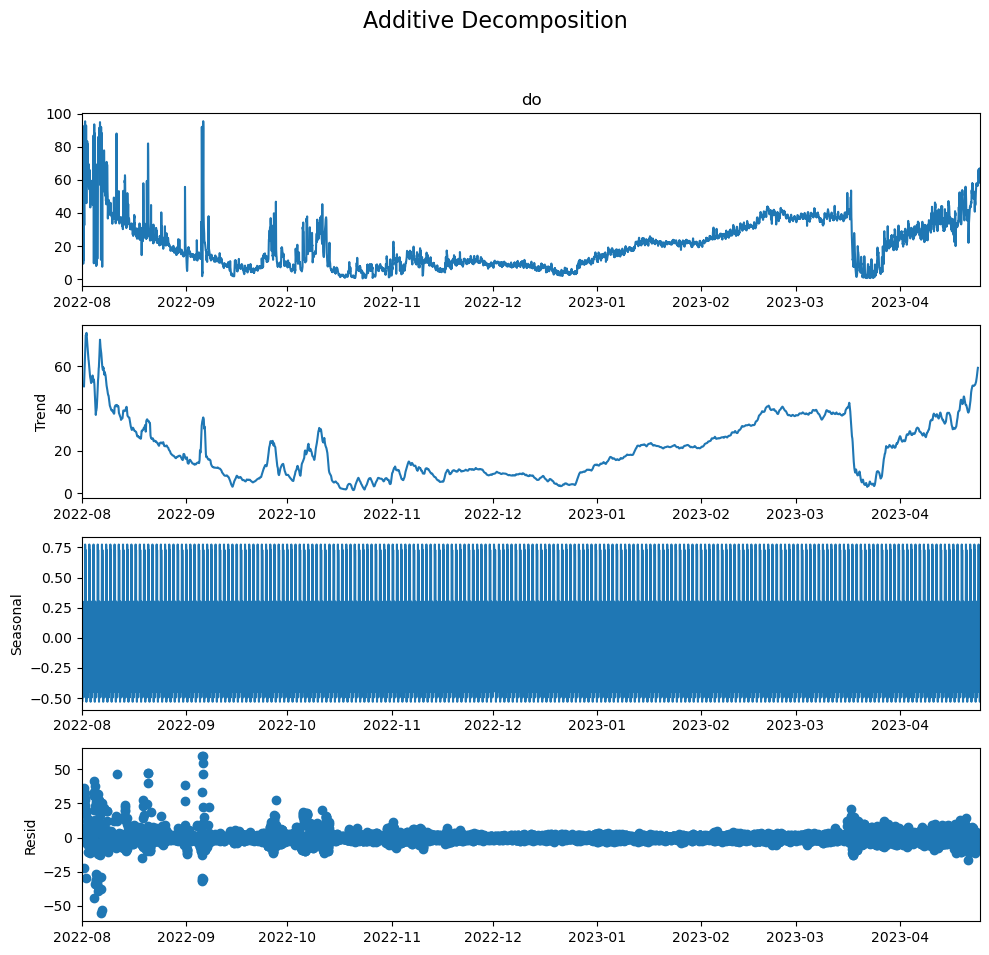

In [50]:
# Additive Decomposition
additive_decomposition = seasonal_decompose(df_hourly['do'].dropna(), model='additive', period=30)
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

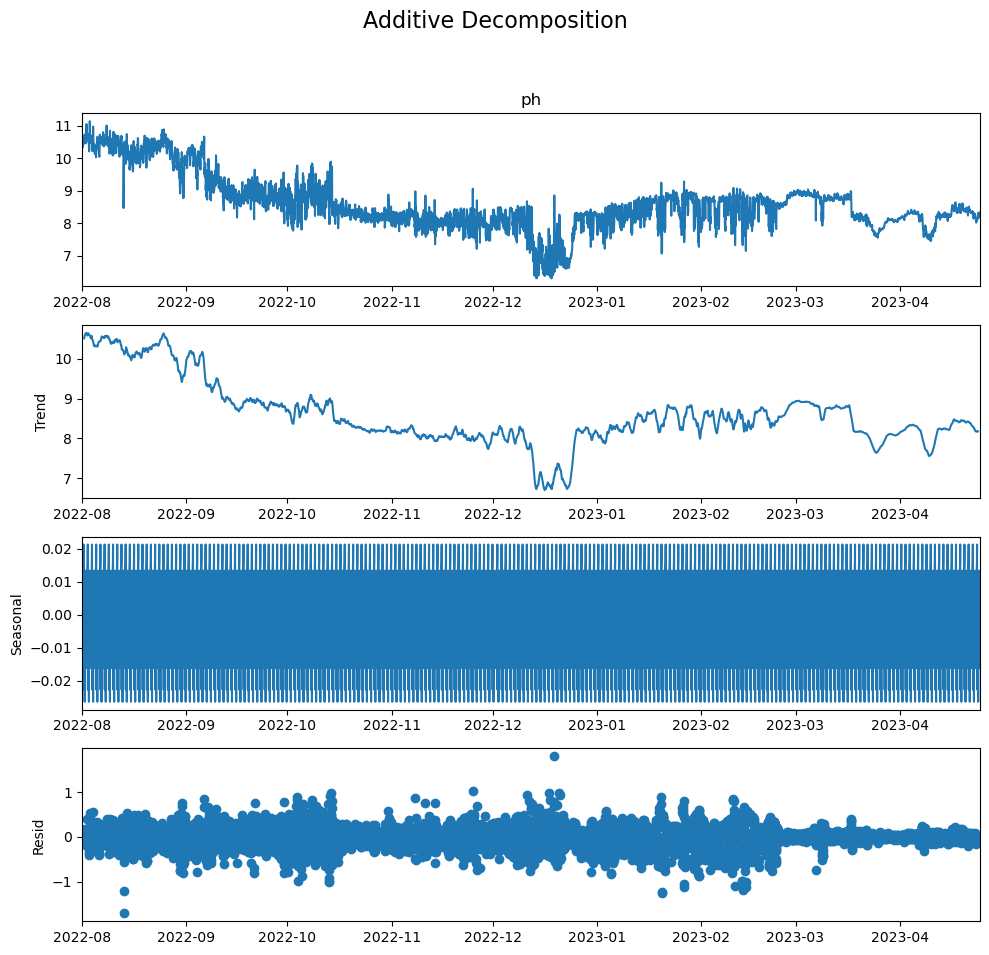

In [51]:
# Additive Decomposition
additive_decomposition = seasonal_decompose(df_hourly['ph'].dropna(), model='additive', period=30)
plt.rcParams.update({'figure.figsize': (10,10)})
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [52]:
df_hourly['temperature_new'].corr(df_hourly['do'])

0.1418296356298901

In [53]:
df_hourly['temperature'].corr(df_hourly['do'])

0.1418296356298901

In [54]:
df_hourly['temperature'].corr(df_hourly['ph'])

0.7374641071361201

In [55]:
df_hourly['temperature'].corr(df_hourly['ph'])

0.7374641071361201

In [56]:
df_hourly['temperature_new'].corr(df_hourly['ph_new'])

0.7374641071361201

In [57]:
df_under_study= df.resample('h').mean()

In [58]:
df_under_study = df_under_study.dropna()
train, test = train_test_split(df_under_study, test_size=0.1, shuffle=False)
train_t=train[['temperature']]
test_t=test[['temperature']]

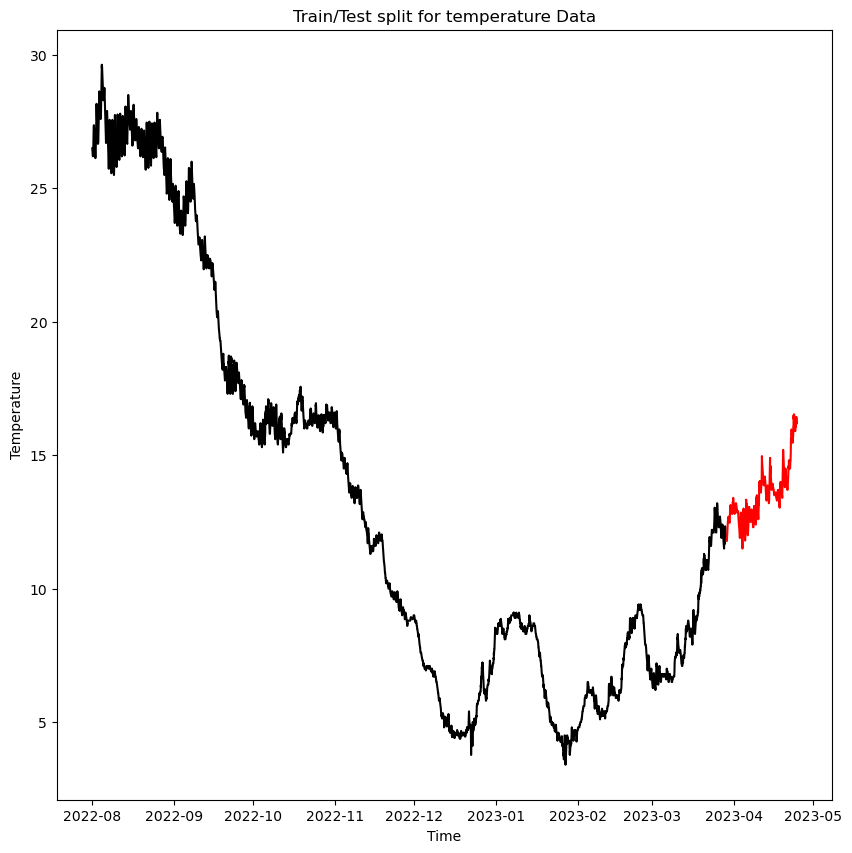

In [59]:
# Plot train and test sets
plt.plot(train['temperature'], color="black")
plt.plot(test['temperature'], color="red")
plt.title("Train/Test split for temperature Data")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.show()

## AR Model

In [60]:
df_hourly = df_hourly.dropna()
train_1, test_1 = train_test_split(df_hourly, test_size=0.1, shuffle=False)
train_n=train_1[['temperature_new']]
test_n=test_1[['temperature_new']]

In [61]:
# introduction of the model 
lags = 1 # the lags used in the model/last hour/first order regression model
ar_model = AutoReg(train_n, lags=lags) # AR model fit to the train set
ar_model_fit = ar_model.fit() # fitting it 
# evaluation of the model 
prediction = ar_model_fit.predict(start=len(train_n), end=len(train_n)+len(test_n)-1)
mae = mean_absolute_error(test_t, prediction)
mse = mean_squared_error(test_t, prediction)
rmse = np.sqrt(mse)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
aic_score = ar_model_fit.aic
print(f'AIC: {aic_score:.3f}')

MAE: 2.329622970640136
MSE: 7.236045290078337
RMSE: 2.689989830850358
AIC: -10682.645


## MA Model

In [62]:
# fit model/ MA(1) is a first-order moving average model.
ma_model = ARIMA(train_n, order=(0, 0, 1))
ma_model_fit = ma_model.fit()
# make prediction
predictions = ma_model_fit.predict(start=len(train_n), end=len(train_n)+len(test_n)-1)
mae = mean_absolute_error(test_n, predictions)
mse = mean_squared_error(test_n, predictions)
rmse = np.sqrt(mse)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
aic_score = ma_model_fit.aic
print(f'AIC: {aic_score:.3f}')

MAE: 0.8301332573527208
MSE: 1.261804764829786
RMSE: 1.1233008345184232
AIC: 31485.110


In [63]:
# fit model/ MA(1) is a first-order moving average model.
ma_model = ARIMA(train_t, order=(0, 0, 1))
ma_model_fit = ma_model.fit()
# make prediction
predictions = ma_model_fit.predict(start=len(train_t), end=len(train_t)+len(test_t)-1)
mae = mean_absolute_error(test_t, predictions)
mse = mean_squared_error(test_t, predictions)
rmse = np.sqrt(mse)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
aic_score = ma_model_fit.aic
print(f'AIC: {aic_score:.3f}')

MAE: 0.8301332573527208
MSE: 1.261804764829786
RMSE: 1.1233008345184232
AIC: 31485.110


## ARMA Model

In [64]:
# fit model
arma_model = ARIMA(train_n, order=(1, 0, 1))
arma_model_fit = arma_model.fit()
# make prediction
predictions = arma_model_fit.predict(start=len(train_n), end=len(train_n)+len(test_n)-1)
mae = mean_absolute_error(test_n, predictions)
mse = mean_squared_error(test_n, predictions)
rmse = np.sqrt(mse)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
aic_score = arma_model_fit.aic
print(f'AIC: {aic_score:.3f}')

MAE: 1.5846051970600272
MSE: 3.4732191806372383
RMSE: 1.8636574740647054
AIC: -11168.937


## Exponential Smoothing

In [65]:
def find_best_parameters(data, seasonal_periods):
    values = np.linspace(0.1, 1.0, 10)
    param_values = product(values, repeat=3)
    best_aic = float('inf')
    best_params = None
    for alpha, beta, gamma in param_values:
        exp_model = ExponentialSmoothing(
            data,
            seasonal_periods=seasonal_periods,
            trend='add',
            seasonal='add',
            initialization_method='estimated',
            use_boxcox=False)
        fit = exp_model.fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)
        aic = fit.aic
        if aic < best_aic:
            best_aic = aic
            best_params = (alpha, beta, gamma)
    return best_params

In [66]:
exp = find_best_parameters(train_t, 4)

In [67]:
# Winter's Exponential Smoothing
exp_model = ExponentialSmoothing(train_t,trend='add', damped=True,seasonal = 'add',seasonal_periods=4)
alpha = exp[0]
beta = exp[1]
gamma = exp[2]
exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)
# make prediction
predictions = exp_model_fit.predict(start=len(train_t), end=len(train_t)+len(test_t)-1)
mae = mean_absolute_error(test_t, predictions)
mse = mean_squared_error(test_t, predictions)
rmse = np.sqrt(mse)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
aic_score = exp_model_fit.aic
print(f'AIC: {aic_score:.3f}')

MAE: 1.9418829985170714
MSE: 4.89221826005354
RMSE: 2.211835947816551
AIC: -27749.030


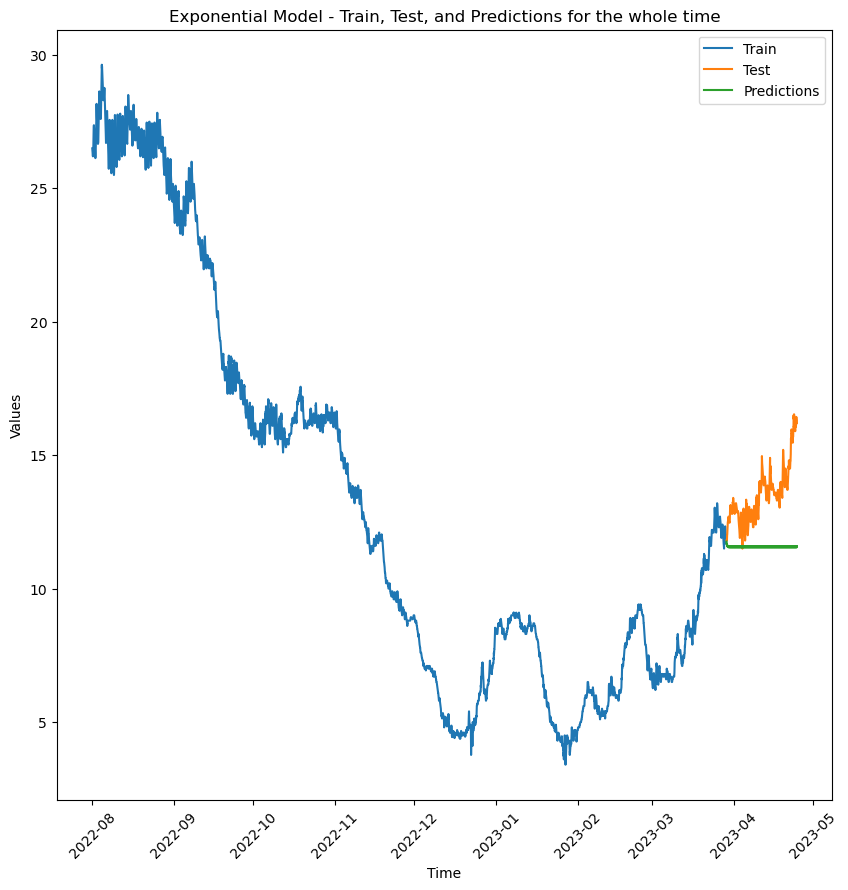

In [68]:
#all train data 
train_series = train_t['temperature']
test_series = test_t['temperature']
# First, we need to create a new index for the predictions
pred_index = test_series.index
# Plot the training data
plt.plot(train_series.index, train_series, label='Train')
# Plot the test data
plt.plot(test_series.index, test_series, label='Test')
# Plot the predictions with the new index
plt.plot(pred_index, predictions, label='Predictions')
# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Exponential Model - Train, Test, and Predictions for the whole time')
plt.legend()
plt.xticks(rotation=45)
plt.show()

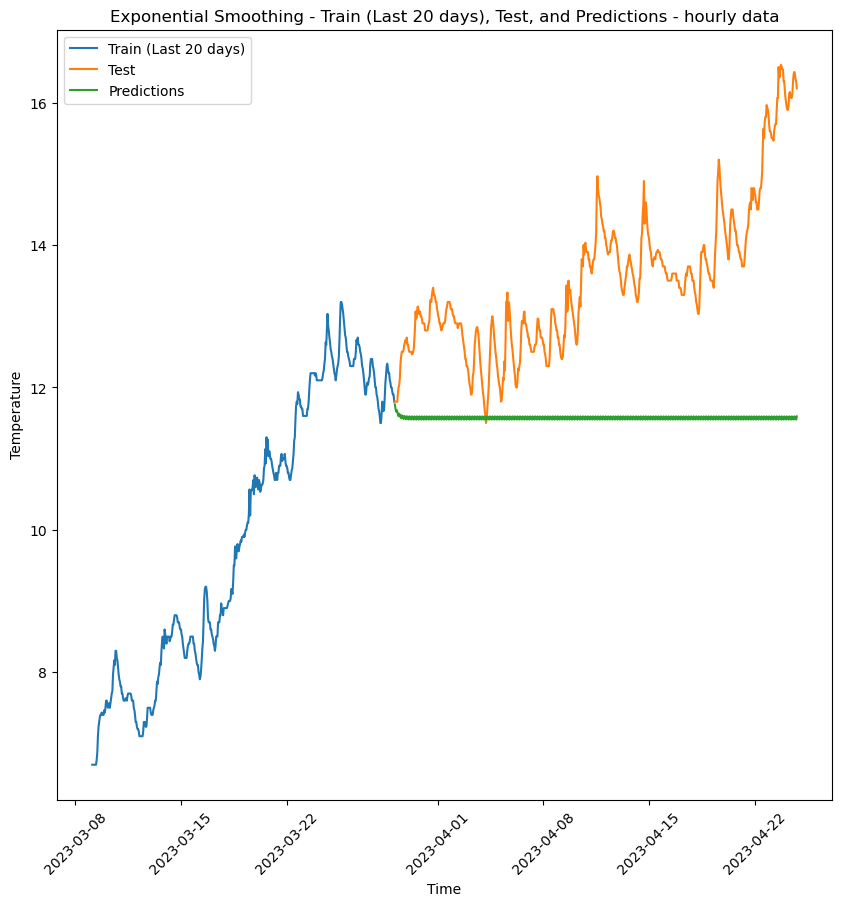

In [69]:
# Close-up to last 20 days
train_series = train_t['temperature']
test_series = test_t['temperature']
last_date = train_series.index[-1]
one_month_ago = last_date - pd.DateOffset(days=20)
# Subset the train_series for the last month
last_month_train_series = train_series[one_month_ago:last_date]
# Plot the training data (last month only)
plt.plot(last_month_train_series.index, last_month_train_series, label='Train (Last 20 days)')
# Plot the test data
plt.plot(test_series.index, test_series, label='Test')
# Plot the predictions with the new index
plt.plot(pred_index, predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Exponential Smoothing - Train (Last 20 days), Test, and Predictions - hourly data')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Sensitivity Analysis for Exponential Smoothing

In [70]:
df_hourly_cleaned = df_hourly.drop(pd.to_datetime('2023-04-22'))
train_daily, test_daily = train_test_split(df_hourly_cleaned, test_size=0.1, shuffle=False)
train_t_daily = train_daily[['temperature']]
test_t_daily = test_daily[['temperature']]

# Without last 24 samples
train_t_sen = train_t[['temperature']].iloc[:-24] #all except last 24
test_t_sen = pd.concat([train_t[['temperature']].iloc[-24:],test_t[['temperature']].iloc[:-24]]) 
exp_model = ExponentialSmoothing(train_t_sen,trend='add', damped=True,seasonal = 'add',seasonal_periods=4)
alpha = exp[0]
beta = exp[1]
gamma = exp[2]
exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)
predictions = exp_model_fit.forecast(steps=len(test_t_sen))
mae = mean_absolute_error(test_t_sen, predictions)
mse = mean_squared_error(test_t_sen, predictions)
aic_score = exp_model_fit.aic
rmse = np.sqrt(mse)
print(f'Test MAE: {mae:.3f}')
print(f'Test MSE: {mse:.3f}')
print(f'Test RMSE: {rmse:.3f}')
print(f'AIC: {aic_score:.3f}')

# Add the last 24 samples back to the time series
train_t = train_t[['temperature']]
test_t = test_t[['temperature']]
exp_model = ExponentialSmoothing(train_t,trend='add', damped=True,seasonal = 'add',seasonal_periods=4)
alpha = exp[0]
beta = exp[1]
gamma = exp[2]
exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)
predictions = exp_model_fit.forecast(steps=len(test_t))
mae = mean_absolute_error(test_t, predictions)
mse = mean_squared_error(test_t, predictions)
rmse = np.sqrt(mse)
aic_score = exp_model_fit.aic
print(f'Test MAE: {mae:.3f}')
print(f'Test MSE: {mse:.3f}')
print(f'Test RMSE: {rmse:.3f}')
print(f'AIC: {aic_score:.3f}')

Test MAE: 1.898
Test MSE: 4.525
Test RMSE: 2.127
AIC: -27637.329
Test MAE: 1.942
Test MSE: 4.892
Test RMSE: 2.212
AIC: -27749.030


## ARIMA Model

p: The number of lag observations included in the model, also called the lag order.

d: The number of times that the raw observations are differenced, also called the degree of differencing.

q: The size of the moving average window, also called the order of moving average.

In [71]:
warnings.filterwarnings("ignore")

def optimize_ARIMA(order_list, exog):
    results = []
    for order in tqdm(order_list):
        model_arima = ARIMA(exog, order=order)
        try:
            results_arima = model_arima.fit()
        except:
            continue
        ma_params = results_arima.params[-order[2]:]
        roots = np.roots(np.concatenate(([1], -ma_params)))
        if np.any(np.abs(roots) >= 1):
            continue
        aic = results_arima.aic
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df
ps = range(0, 10, 1)
d = 1
qs = range(0, 10, 1)
parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
result_d = optimize_ARIMA(order_list=order_list, exog=train_t)

100%|██████████| 100/100 [10:39<00:00,  6.39s/it]


In [72]:
ARIMA_optimized=result_d.iloc[0,0]

In [73]:
# fit model
arima_model = ARIMA(train_t, order=ARIMA_optimized)
arima_model_fit = arima_model.fit()
# make prediction
predictions = arima_model_fit.predict(start=len(train_t), end=len(train_t)+len(test_t)-1)
mae = mean_absolute_error(test_t, predictions)
mse = mean_squared_error(test_t, predictions)
rmse = np.sqrt(mse)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
aic_score = arima_model_fit.aic
print(f'AIC: {aic_score:.3f}')

MAE: 1.4931491232065184
MSE: 3.2815587324102515
RMSE: 1.8115073095105776
AIC: -12990.642


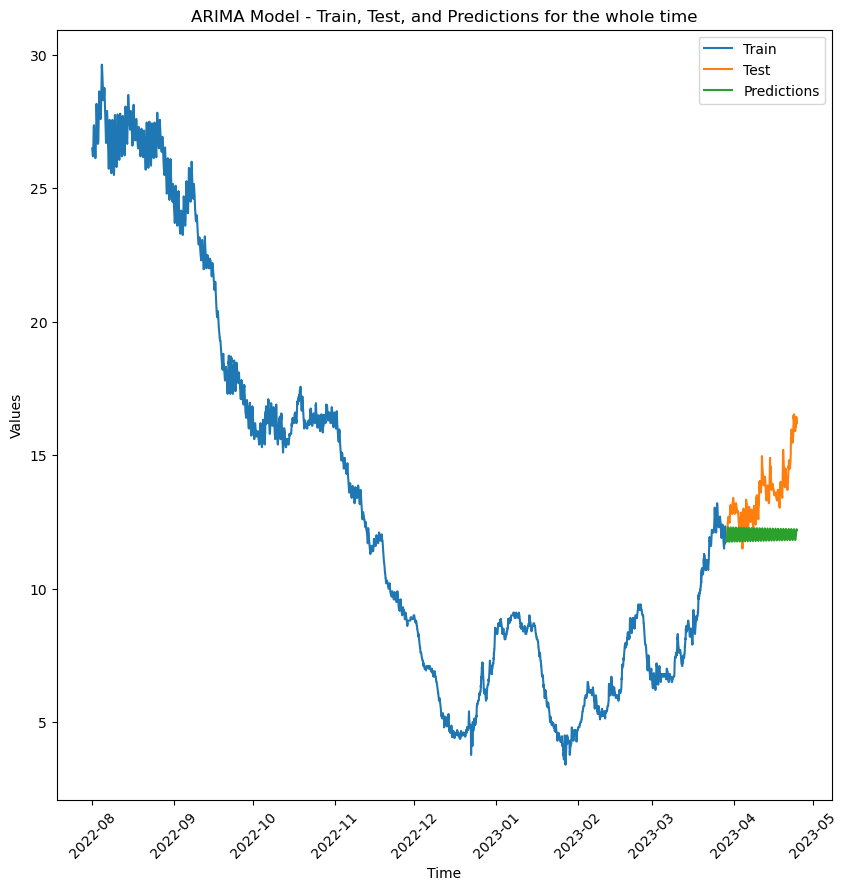

In [74]:
train_series = train_t['temperature']
test_series = test_t['temperature']

# First, we need to create a new index for the predictions
pred_index = test_series.index

# Plot the training data
plt.plot(train_series.index, train_series, label='Train')

# Plot the test data
plt.plot(test_series.index, test_series, label='Test')

# Plot the predictions with the new index
plt.plot(pred_index, predictions, label='Predictions')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('ARIMA Model - Train, Test, and Predictions for the whole time')
plt.legend()

plt.xticks(rotation=45)
plt.show()

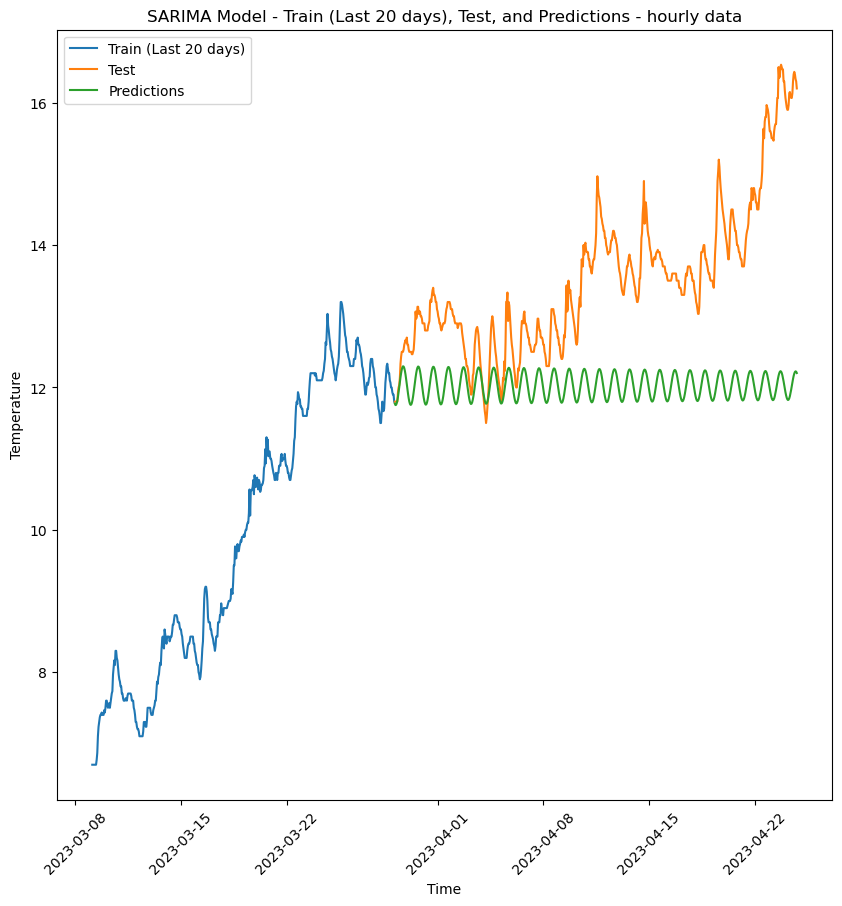

In [75]:
# Close-up to last 20 days
train_series = train_t['temperature']
test_series = test_t['temperature']
last_date = train_series.index[-1]
one_month_ago = last_date - pd.DateOffset(days=20)
# Subset the train_series for the last month
last_month_train_series = train_series[one_month_ago:last_date]

# Plot the training data (last month only)
plt.plot(last_month_train_series.index, last_month_train_series, label='Train (Last 20 days)')

# Plot the test data
plt.plot(test_series.index, test_series, label='Test')

# Plot the predictions with the new index
plt.plot(pred_index, predictions, label='Predictions')

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('SARIMA Model - Train (Last 20 days), Test, and Predictions - hourly data')
plt.legend()

plt.xticks(rotation=45)
plt.show()

## SARIMA Model - Hourly Data 

In [76]:
train, test = train_test_split(df_under_study, test_size=0.1, shuffle=False)
train_t=train[['temperature']]
test_t=test[['temperature']]

In [77]:
def check_seasonal_differencing(ts, max_d=5):
    for d in range(max_d+1):
        adf_result = adfuller(ts.diff(d).dropna())
        p_value = adf_result[1]
        if p_value < 0.05:
            break
    if d > 0:
        for D in range(1, 13):
            adf_result = adfuller(ts.diff(D*4).dropna())
            p_value = adf_result[1]
            if p_value < 0.05:
                return D, d
    else:
        return 0, d

In [78]:
D_factor=check_seasonal_differencing(train_t, max_d=2)

In [79]:
def check_moving_average(ts):
    seasonal_ma = ts.diff(4)
    acf_vals = acf(seasonal_ma.dropna(), fft=False)
    # Determine order of seasonal moving average component
    Q = 0
    for i in range(1, len(acf_vals)):
        if abs(acf_vals[i]) > 1.96/np.sqrt(len(seasonal_ma)):
            if i % 4 == 0:
                Q = i//4
            else:
                break
    return Q
Q_factor = check_moving_average(train_t) # this is the moving average for the seasonal trend

In [80]:
def optimize_SARIMA(order_list, exog):
    results = []
    for order in tqdm(order_list):
        model_sarima = SARIMAX(exog,order=order,seasonal_order=(0, D_factor[0], Q_factor, 4)).fit(disp=-1)
        ma_params = model_sarima.params[-order[2]:]
        roots = np.roots(np.concatenate(([1], -ma_params)))
        if np.any(np.abs(roots) >= 1):
            continue
        aic = model_sarima.aic
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df
# running now all possible options 
ps = range(0, 10, 1)
ds = range(1, 2, 1)
qs = range(0, 10, 1)
parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for p in ps:
    for d in ds:
        for q in qs:
            order_list.append((p, d, q))
result_d = optimize_SARIMA(order_list=order_list, exog=train_t) 

100%|██████████| 100/100 [18:45<00:00, 11.26s/it]


In [81]:
SARIMA_optimal = result_d.iloc[0, 0]

## Evaluating SARIMA in order to predict the test set

In [82]:
# fit model
sarima_model = SARIMAX(train_t, order=SARIMA_optimal, seasonal_order=(0, D_factor[0], Q_factor, 4))
sarima_model_fit = sarima_model.fit()
# make prediction
predictions = sarima_model_fit.predict(start=len(train_t), end=len(train_t)+len(test_t)-1)
mae = mean_absolute_error(test_t, predictions)
mse = mean_squared_error(test_t, predictions)
rmse = np.sqrt(mse)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
aic_score = sarima_model_fit.aic
print(f'AIC: {aic_score:.3f}')

MAE: 2.2589659220063543
MSE: 6.947401485352446
RMSE: 2.635792382823891
AIC: -12230.746


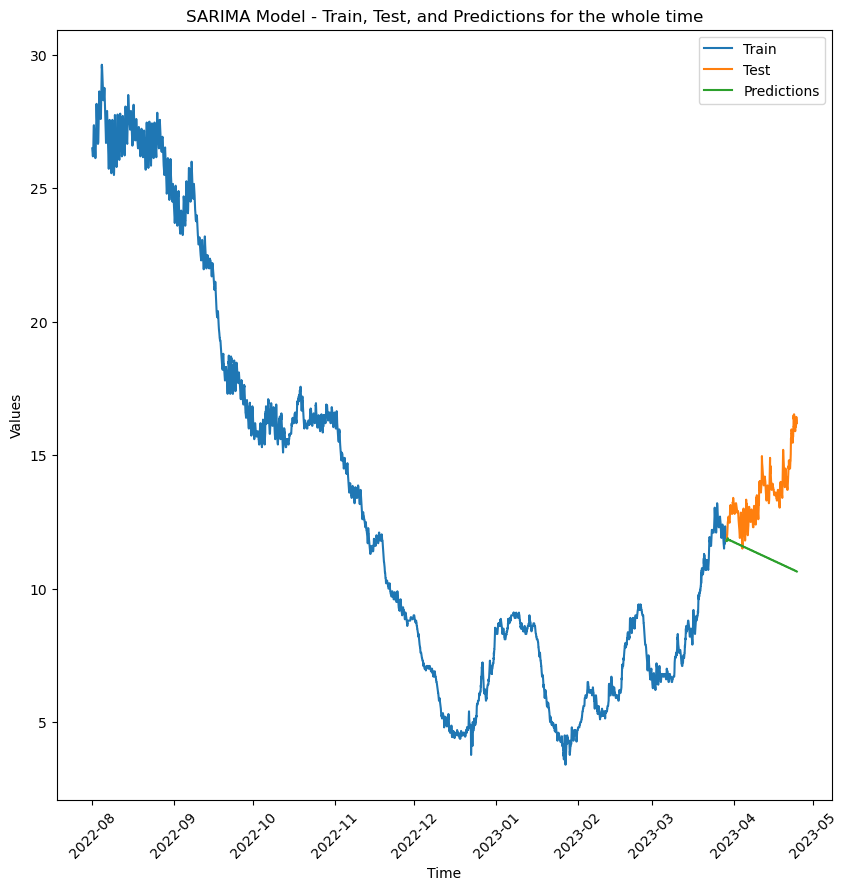

In [83]:
#all train data 
train_series = train_t['temperature']
test_series = test_t['temperature']

# First, we need to create a new index for the predictions
pred_index = test_series.index

# Plot the training data
plt.plot(train_series.index, train_series, label='Train')

# Plot the test data
plt.plot(test_series.index, test_series, label='Test')

# Plot the predictions with the new index
plt.plot(pred_index, predictions, label='Predictions')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('SARIMA Model - Train, Test, and Predictions for the whole time')
plt.legend()

plt.xticks(rotation=45)
plt.show()


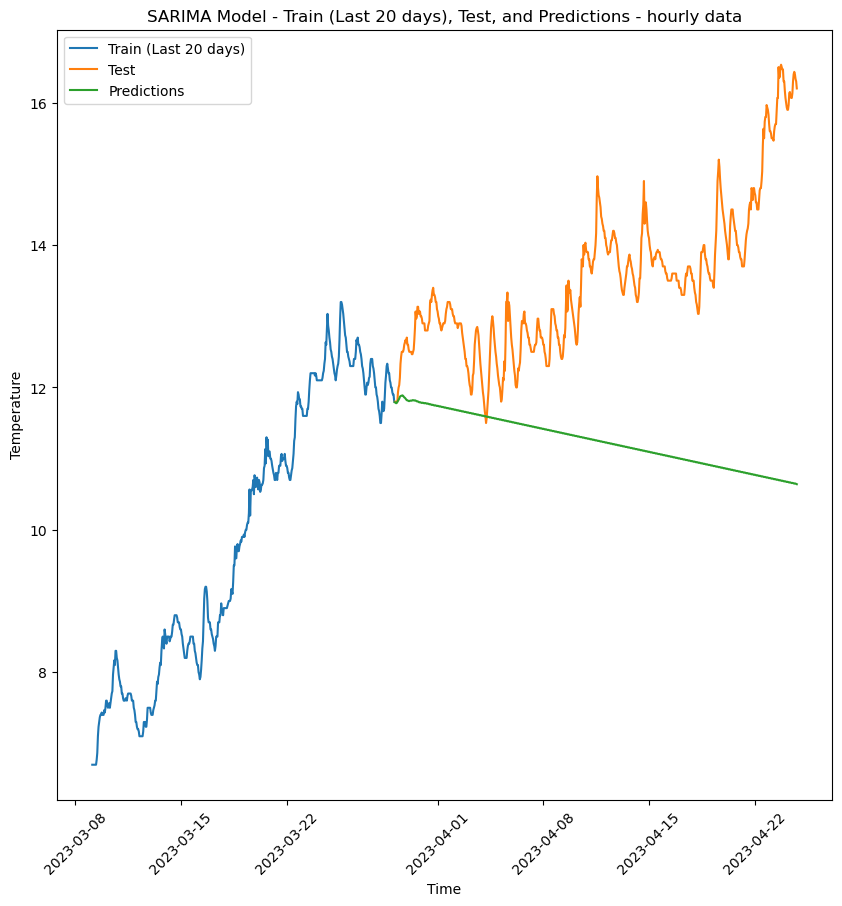

In [84]:
# Close-up to last 20 days
train_series = train_t['temperature']
test_series = test_t['temperature']
last_date = train_series.index[-1]
one_month_ago = last_date - pd.DateOffset(days=20)
# Subset the train_series for the last month
last_month_train_series = train_series[one_month_ago:last_date]

# Plot the training data (last month only)
plt.plot(last_month_train_series.index, last_month_train_series, label='Train (Last 20 days)')

# Plot the test data
plt.plot(test_series.index, test_series, label='Test')

# Plot the predictions with the new index
plt.plot(pred_index, predictions, label='Predictions')

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('SARIMA Model - Train (Last 20 days), Test, and Predictions - hourly data')
plt.legend()

plt.xticks(rotation=45)
plt.show()


## Evaluating SARIMA in order to predict future data

In [85]:
temperature =df_under_study[['temperature']]

In [86]:
# fit model
sarima_model = SARIMAX(temperature, 
                       order=SARIMA_optimal, 
                       seasonal_order=(0, D_factor[0], Q_factor, 4))
sarima_model_fit = sarima_model.fit()
# make prediction for the future
predictions = sarima_model_fit.predict(start=len(temperature), end=len(temperature)+23)
aic_score = sarima_model_fit.aic
print(f'AIC: {aic_score:.3f}')

AIC: -13319.095


In [87]:
last_timestamp = pd.to_datetime(temperature.index[-1])
new_index = pd.date_range(start=last_timestamp, periods=25, closed='right', freq='H')
predictions_df = pd.DataFrame(predictions)
predictions_df.index = new_index

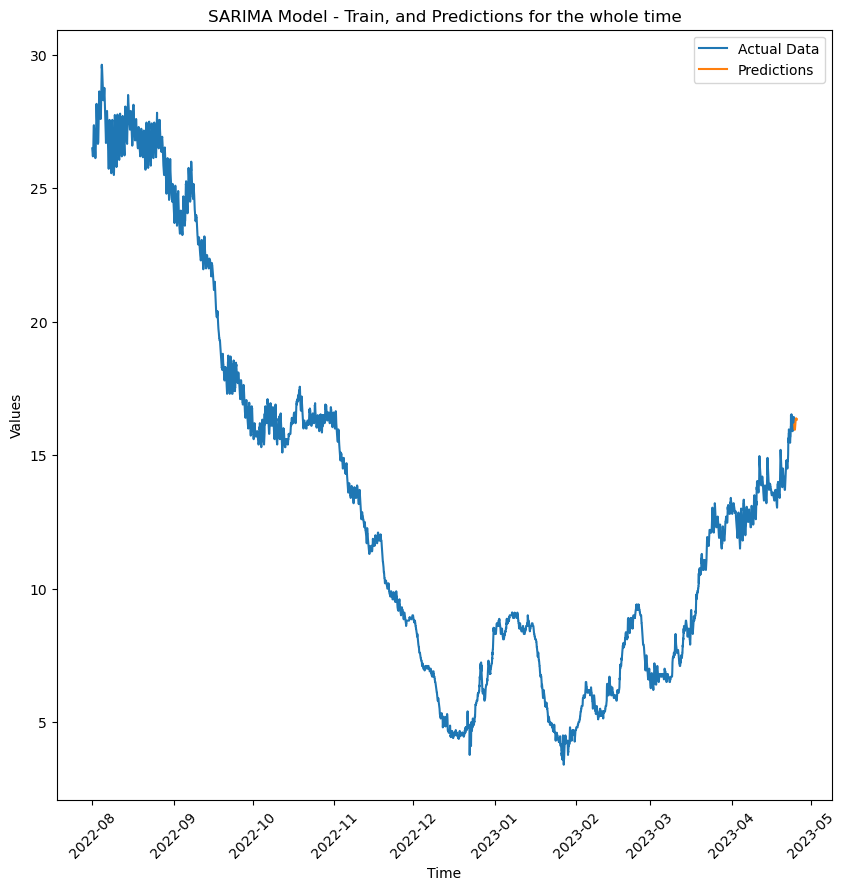

In [88]:
train_series = temperature['temperature']
predictions_series = predictions_df
plt.plot(train_series.index, train_series, label='Actual Data')
plt.plot(predictions_series.index, predictions_series, label='Predictions')
# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('SARIMA Model - Train, and Predictions for the whole time')
plt.legend()
plt.xticks(rotation=45)
plt.show()

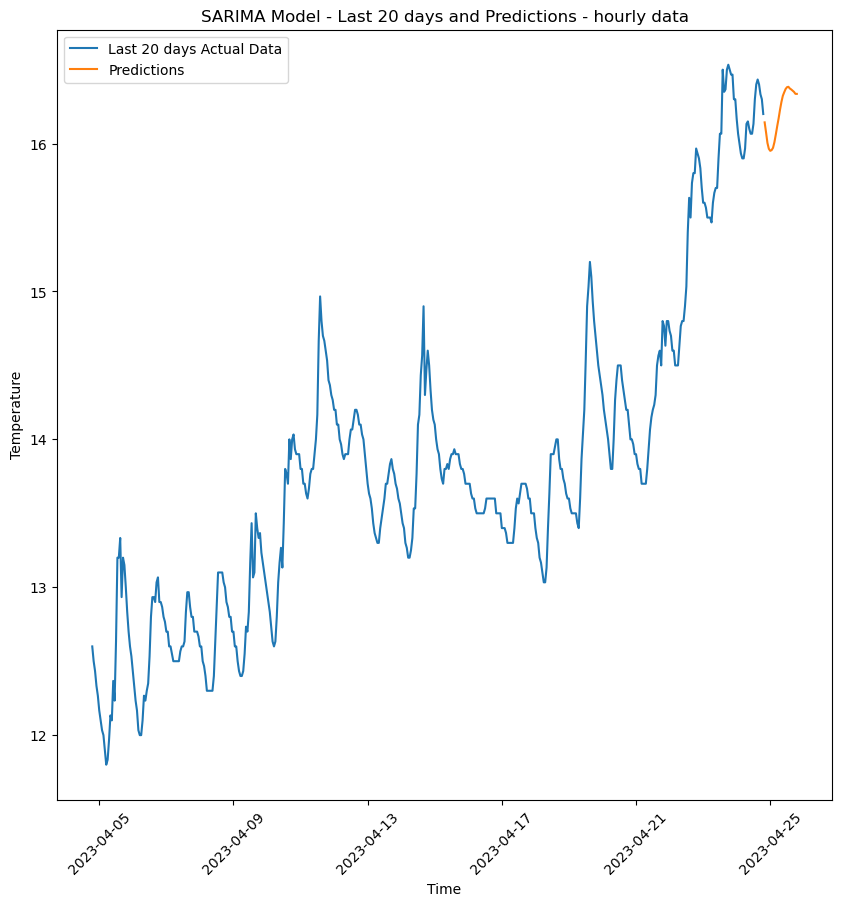

In [89]:
last_date = train_series.index[-1]
one_month_ago = last_date - pd.DateOffset(days=20)
last_month_train_series = train_series[one_month_ago:last_date]
predictions_series = predictions_df
plt.plot(last_month_train_series.index, last_month_train_series, label='Last 20 days Actual Data')
plt.plot(predictions_series.index, predictions_series, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('SARIMA Model - Last 20 days and Predictions - hourly data')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## SARIMA - Sensitivity Analysis

In [90]:
df_hourly_cleaned = df_hourly.drop(pd.to_datetime('2023-04-22'))

In [91]:
train_daily, test_daily = train_test_split(df_hourly_cleaned, test_size=0.1, shuffle=False)
train_t_daily = train_daily[['temperature']]
test_t_daily = test_daily[['temperature']]

In [92]:
##adding and deleting last 24 data points

"""
Change the next ones depending on the best model form above
"""
order = SARIMA_optimal
seasonal_order = (0, D_factor[0], Q_factor, 4)

# Without last 24 samples
train_t_sen = train_t[['temperature']].iloc[:-24] #all except last 24
test_t_sen = pd.concat([train_t[['temperature']].iloc[-24:],test_t[['temperature']].iloc[:-24]]) 

sarima_model = SARIMAX(train_t_sen, order=order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit()

predictions = sarima_model_fit.forecast(steps=len(test_t_sen))
mae = mean_absolute_error(test_t_sen, predictions)
mse = mean_squared_error(test_t_sen, predictions)
aic_score = sarima_model_fit.aic
print('This is the different split')
print(f'Test MAE: {mae:.3f}')
print(f'Test MSE: {mse:.3f}')
print(f'AIC: {aic_score:.3f}')

# Add the last 24 samples back to the time series
train_t = train_t[['temperature']]
test_t = test_t[['temperature']]
sarima_model = SARIMAX(train_t, order=order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit()
predictions = sarima_model_fit.forecast(steps=len(test_t))
mae = mean_absolute_error(test_t, predictions)
mse = mean_squared_error(test_t, predictions)
aic_score = sarima_model_fit.aic
print('This is the initial split')
print(f'Test MAE: {mae:.3f}')
print(f'Test MSE: {mse:.3f}')
print(f'AIC: {aic_score:.3f}')

This is the different split
Test MAE: 2.267
Test MSE: 6.844
AIC: -12187.619
This is the initial split
Test MAE: 2.259
Test MSE: 6.947
AIC: -12230.746


## Exponential Smoothing, ARIMA, SARIMA model - DAILY DATA

### Exponential smoothing

In [93]:
#running on test set
train_daily, test_daily = train_test_split(df_daily, test_size=0.1, shuffle=False)
train_t_daily = train_daily[['temperature']]
test_t_daily = test_daily[['temperature']]

In [94]:
factor = find_best_parameters(train_t_daily, 4)

In [95]:
# Winter's Exponential Smoothing
exp_model = ExponentialSmoothing(train_t_daily,trend='add', damped=True,seasonal = 'add',seasonal_periods=4,initialization_method='estimated',
        use_boxcox=False)
alpha = factor[0]
beta = factor[1]
gamma = factor[2]
exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)
# make prediction
predictions = exp_model_fit.predict(start=len(train_t_daily), end=len(train_t_daily)+len(test_t_daily)-1)
mae = mean_absolute_error(test_t_daily, predictions)
mse = mean_squared_error(test_t_daily, predictions)
rmse = np.sqrt(mse)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
aic_score = exp_model_fit.aic
print(f'AIC: {aic_score:.3f}')

MAE: 1.6223736702865597
MSE: 3.688656295928538
RMSE: 1.9205874871842048
AIC: -462.217


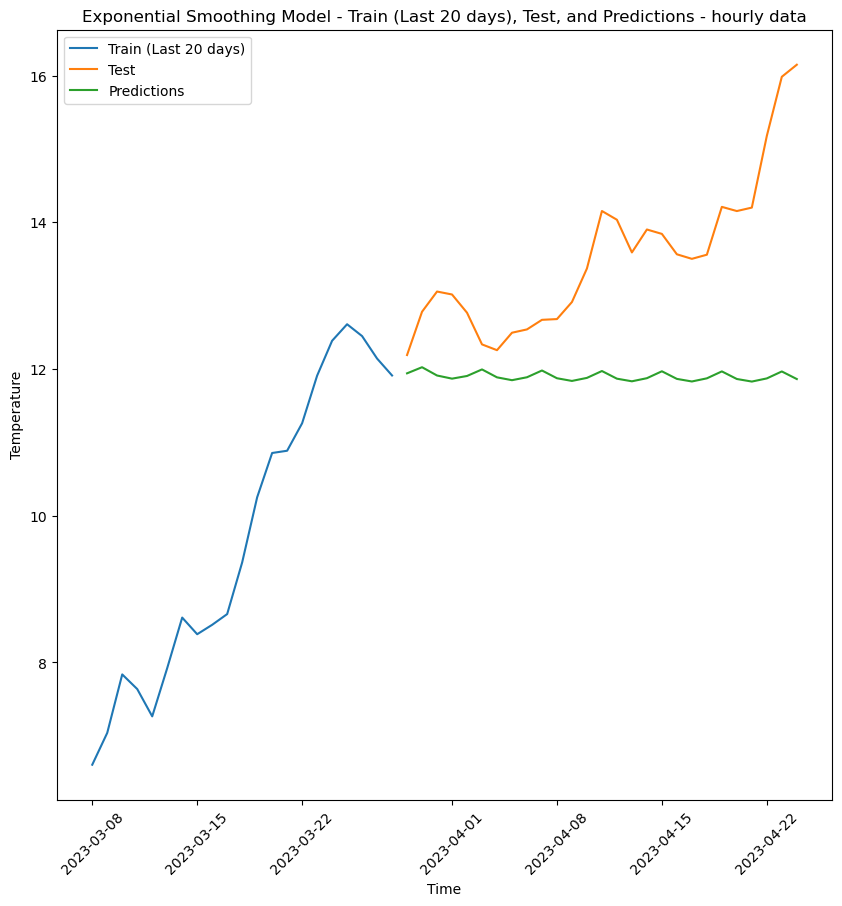

In [96]:
# Close-up to last 20 days
pred_index=predictions.index
train_series = train_t_daily['temperature']
test_series = test_t_daily['temperature']
last_date = train_series.index[-1]
one_month_ago = last_date - pd.DateOffset(days=20)
# Subset the train_series for the last month
last_month_train_series = train_series[one_month_ago:last_date]
# Plot the training data (last month only)
plt.plot(last_month_train_series.index, last_month_train_series, label='Train (Last 20 days)')
# Plot the test data
plt.plot(test_series.index, test_series, label='Test')

# Plot the predictions with the new index
plt.plot(pred_index, predictions, label='Predictions')

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Exponential Smoothing Model - Train (Last 20 days), Test, and Predictions - hourly data')
plt.legend()

plt.xticks(rotation=45)
plt.show()


### ARIMA 

In [97]:
ps = range(0, 10, 1)
d = 1
qs = range(0, 10, 1)
parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
result_d = optimize_ARIMA(order_list=order_list, exog=train_t_daily)

100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


In [98]:
ARIMA_optimized=result_d.iloc[0,0]

In [99]:
# fit model
arima_model = ARIMA(train_t_daily, order=ARIMA_optimized)
arima_model_fit = arima_model.fit()
# make prediction
predictions = arima_model_fit.predict(start=len(train_t_daily), end=len(train_t_daily)+len(test_t_daily)-1)
mae = mean_absolute_error(test_t_daily, predictions)
mse = mean_squared_error(test_t_daily, predictions)
rmse = np.sqrt(mse)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
aic_score = arima_model_fit.aic
print(f'AIC: {aic_score:.3f}')

MAE: 1.8038671127721133
MSE: 4.308980091833395
RMSE: 2.0758082984306125
AIC: 128.813


(array([19424., 19431., 19438., 19448., 19455., 19462., 19469.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

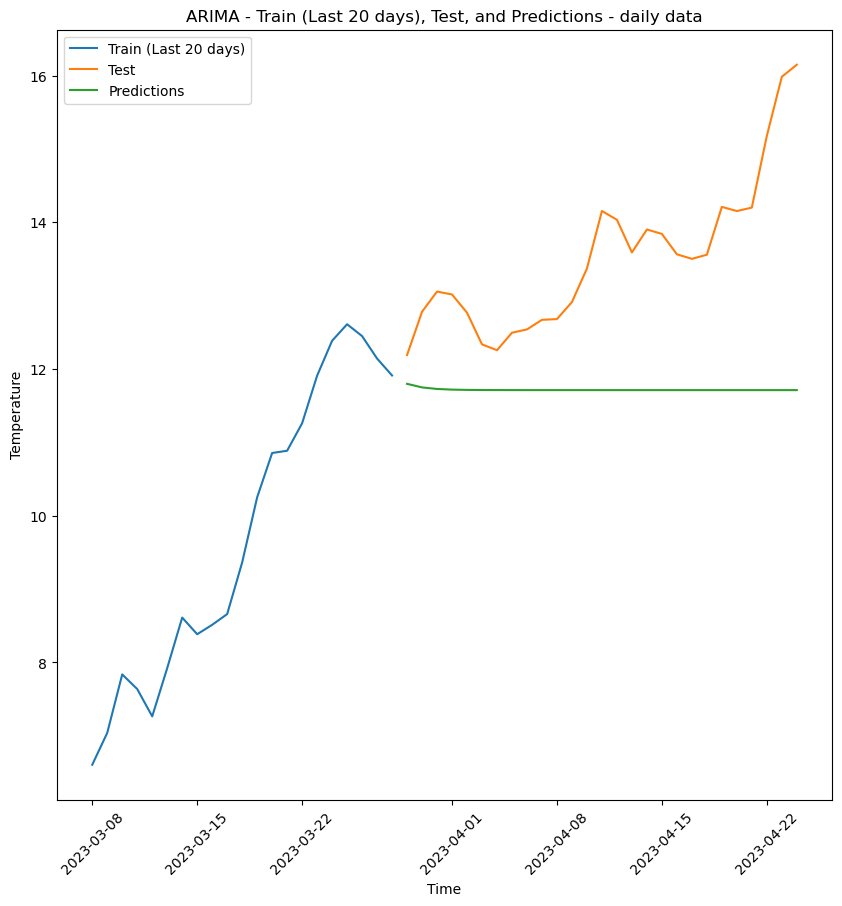

In [100]:
# Close-up to last 20 days
train_series = train_t_daily['temperature']
test_series = test_t_daily['temperature']
pred_index=predictions.index
last_date = train_series.index[-1]
one_month_ago = last_date - pd.DateOffset(days=20)
pred_index = test_series.index
# Subset the train_series for the last month
last_month_train_series = train_series[one_month_ago:last_date]
# Plot the training data (last month only)
plt.plot(last_month_train_series.index, last_month_train_series, label='Train (Last 20 days)')

# Plot the test data
plt.plot(test_series.index, test_series, label='Test')

# Plot the predictions with the new index
plt.plot(pred_index, predictions, label='Predictions')

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('ARIMA - Train (Last 20 days), Test, and Predictions - daily data')
plt.legend()

plt.xticks(rotation=45)

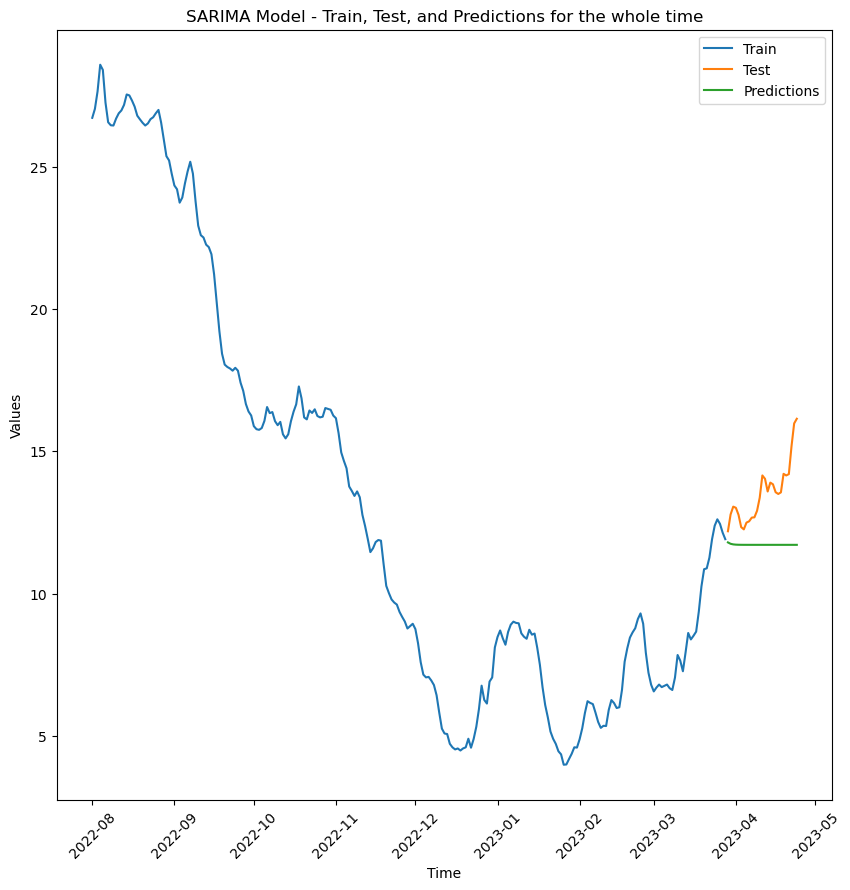

In [101]:
#all train data 
train_series = train_t_daily['temperature']
test_series = test_t_daily['temperature']

# First, we need to create a new index for the predictions
pred_index = test_series.index

# Plot the training data
plt.plot(train_series.index, train_series, label='Train')

# Plot the test data
plt.plot(test_series.index, test_series, label='Test')

# Plot the predictions with the new index
plt.plot(pred_index, predictions, label='Predictions')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('SARIMA Model - Train, Test, and Predictions for the whole time')
plt.legend()
plt.xticks(rotation=45)

plt.show()

### SARIMA

In [102]:
def check_seasonal_differencing(ts, max_d=5):
    # Check for non-seasonal differencing
    for d in range(max_d+1):
        adf_result = adfuller(ts.diff(d).dropna())
        p_value = adf_result[1]
        if p_value < 0.05:
            break
    
    # Check for seasonal differencing
    if d > 0:
        for D in range(1, 13):
            adf_result = adfuller(ts.diff(D*4).dropna())
            p_value = adf_result[1]
            if p_value < 0.05:
                return D, d
    else:
        return 0, d

In [103]:
D_factor = check_seasonal_differencing(train_t_daily, max_d=2)

In [104]:
# Seasonally difference the time series
def check_moving_average(ts):
    seasonal_ma = ts.diff(4)
    acf_vals = acf(seasonal_ma.dropna(), fft=False)
    # Determine order of seasonal moving average component
    Q = 0
    for i in range(1, len(acf_vals)):
        if abs(acf_vals[i]) > 1.96/np.sqrt(len(seasonal_ma)):
            if i % 4 == 0:
                Q = i//4
            else:
                break
    return Q
Q_factor = check_moving_average(train_t_daily)

In [105]:
def optimize_SARIMA(order_list, exog):
    results = []
    for order in tqdm(order_list):
        model_sarima = SARIMAX(exog,order=order,seasonal_order=(0, D_factor[0], Q_factor, 4)).fit(disp=-1)
        ma_params = model_sarima.params[-order[2]:]
        roots = np.roots(np.concatenate(([1], -ma_params)))
        if np.any(np.abs(roots) >= 1):
            continue
        aic = model_sarima.aic
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df
ps = range(0, 10, 1)
ds = range(0, 2, 1)
qs = range(0, 10, 1)
parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for p in ps:
    for d in ds:
        for q in qs:
            order_list.append((p, d, q))
result_d = optimize_SARIMA(order_list=order_list, exog=train_t_daily)

100%|██████████| 200/200 [02:44<00:00,  1.21it/s]


In [106]:
SARIMA_optimal = result_d.iloc[0, 0]

In [107]:
# fit model
sarima_model = SARIMAX(train_t_daily, order=SARIMA_optimal, seasonal_order=(0, D_factor[0], Q_factor, 4))
sarima_model_fit = sarima_model.fit()
# make prediction
predictions = sarima_model_fit.predict(start=len(train_t_daily), end=len(train_t_daily)+len(test_t_daily)-1)
mae = mean_absolute_error(test_t_daily, predictions)
mse = mean_squared_error(test_t_daily, predictions)
rmse = np.sqrt(mse)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
aic_score = sarima_model_fit.aic
print(f'AIC: {aic_score:.3f}')

MAE: 0.977131246717724
MSE: 1.4673787243327547
RMSE: 1.2113540870995378
AIC: 150.363


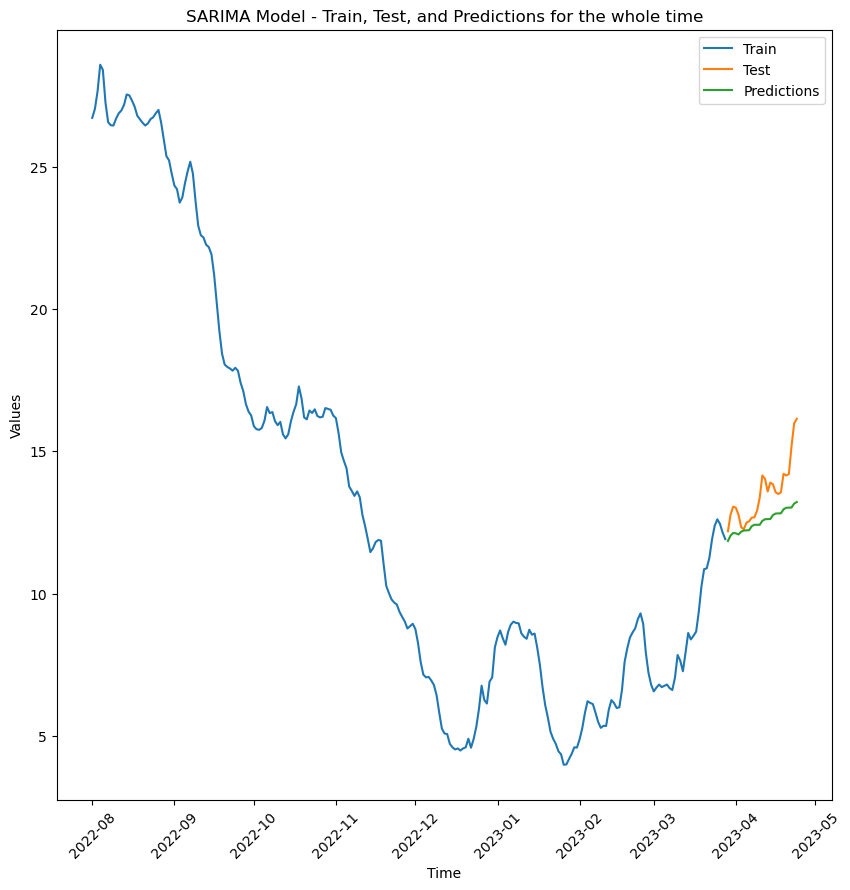

In [108]:
#all train data 
train_series = train_t_daily['temperature']
test_series = test_t_daily['temperature']
pred_index=predictions.index
# First, we need to create a new index for the predictions
pred_index = test_series.index

# Plot the training data
plt.plot(train_series.index, train_series, label='Train')

# Plot the test data
plt.plot(test_series.index, test_series, label='Test')

# Plot the predictions with the new index
plt.plot(pred_index, predictions, label='Predictions')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('SARIMA Model - Train, Test, and Predictions for the whole time')
plt.legend()
plt.xticks(rotation=45)

plt.show()


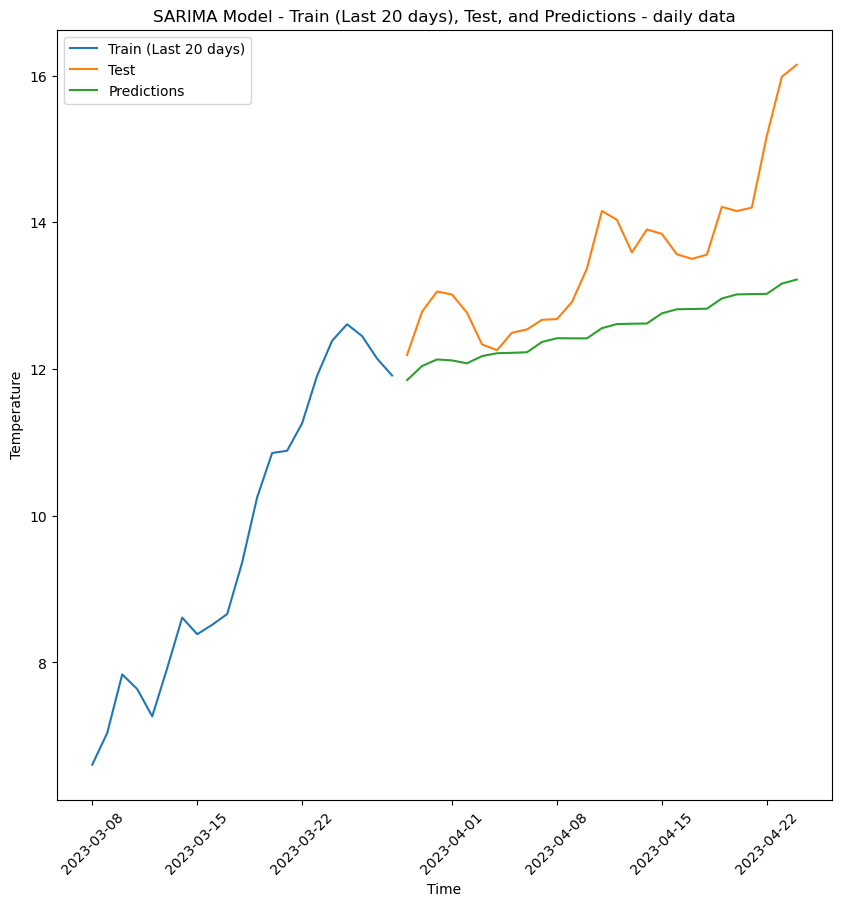

In [109]:
# Close-up to last 20 days
pred_index=predictions.index
train_series = train_t_daily['temperature']
test_series = test_t_daily['temperature']
last_date = train_series.index[-1]
pred_index = test_series.index
one_month_ago = last_date - pd.DateOffset(days=20)

# Subset the train_series for the last month
last_month_train_series = train_series[one_month_ago:last_date]

# Plot the training data (last month only)
plt.plot(last_month_train_series.index, last_month_train_series, label='Train (Last 20 days)')

# Plot the test data
plt.plot(test_series.index, test_series, label='Test')

# Plot the predictions with the new index
plt.plot(pred_index, predictions, label='Predictions')

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('SARIMA Model - Train (Last 20 days), Test, and Predictions - daily data')
plt.legend()

plt.xticks(rotation=45)
plt.show()


# Machine Learning 

In [110]:
headers = {
    'Accept': 'application/json',
}

today = datetime.now().strftime('%Y-%m-%d')
#50.11279431660737, 8.722234876321428
params = {
    'date': '2022-08-01', #from
    'last_date': today,#to
    'lat': '50.11279431660737',
    'lon': '8.722234876321428',
}

r = requests.get('https://api.brightsky.dev/weather', params=params, headers=headers)
print(r.status_code)
resp_dict=json.loads(r.text)
weather = pd.DataFrame.from_records(resp_dict['weather'])

200


In [111]:
weather['timestamp'] =  pd.to_datetime(weather['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f')

In [112]:
#adding month, day, year and hour columns
weather['month'] = weather['timestamp'].dt.month
weather['day'] = weather['timestamp'].dt.day
weather['year'] = weather['timestamp'].dt.year
weather['hour'] = weather['timestamp'].dt.hour
weather['minutes'] = weather['timestamp'].dt.minute

In [113]:
df_all = pd.merge(df_hourly, weather, on=['month','day','year','hour'])
df_all = df_all.rename(columns={'temperature_x': 'water_temperature', 'temperature_y': 'temperature'})

In [114]:
df_all = df_all.sort_values(by=['year', 'month', 'day', 'hour'])
df_all

,water_temperature,orp,ph,do,ec,battery,year,month,day,hour,...,visibility,wind_gust_direction,wind_gust_speed,condition,precipitation_probability,precipitation_probability_6h,solar,fallback_source_ids,icon,minutes_y
0,26.500000,0.976667,10.466667,12.600000,1732.333333,100.000000,2022.0,8.0,1.0,0.0,...,70000,310.0,19.8,dry,None,None,0.0,"{'pressure_msl': 6967, 'wind_speed': 6967, 'su...",cloudy,0
1,26.433333,0.946667,10.466667,12.600000,1749.333333,100.000000,2022.0,8.0,1.0,1.0,...,70000,310.0,24.8,dry,None,None,0.0,"{'pressure_msl': 6967, 'wind_speed': 6967, 'su...",partly-cloudy-night,0
2,26.400000,0.933333,10.460000,12.600000,1741.000000,100.000000,2022.0,8.0,1.0,2.0,...,70000,310.0,19.1,dry,None,None,0.0,"{'pressure_msl': 6967, 'wind_speed': 6967, 'su...",partly-cloudy-night,0
3,26.333333,0.860000,10.380000,12.600000,1734.666667,99.666667,2022.0,8.0,1.0,3.0,...,70000,320.0,19.4,dry,None,None,0.0,"{'pressure_msl': 6967, 'wind_speed': 6967, 'su...",partly-cloudy-night,0
4,26.266667,0.826667,10.323333,12.600000,1722.666667,100.000000,2022.0,8.0,1.0,4.0,...,60000,320.0,20.2,dry,None,None,0.0,"{'pressure_msl': 6967, 'wind_speed': 6967, 'su...",partly-cloudy-day,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6370,16.466667,5.866667,8.093333,56.933333,1577.333333,100.000000,2023.0,4.0,23.0,20.0,...,72080,190.0,21.2,dry,None,None,0.0,"{'pressure_msl': 6967, 'wind_speed': 6967, 'su...",cloudy,0
6371,16.466667,5.790000,8.086667,56.833333,1573.666667,100.000000,2023.0,4.0,23.0,21.0,...,75000,210.0,40.7,dry,None,None,0.0,"{'pressure_msl': 6967, 'wind_speed': 6967, 'su...",cloudy,0
6372,16.300000,5.976667,8.103333,56.833333,1570.000000,100.000000,2023.0,4.0,23.0,22.0,...,75000,210.0,23.4,dry,None,None,0.0,"{'pressure_msl': 6967, 'wind_speed': 6967, 'su...",cloudy,0
6373,16.300000,5.950000,8.106667,56.433333,1563.000000,100.000000,2023.0,4.0,23.0,23.0,...,75000,220.0,28.1,dry,None,None,0.0,"{'pressure_msl': 6967, 'wind_speed': 6967, 'su...",cloudy,0


<AxesSubplot:>

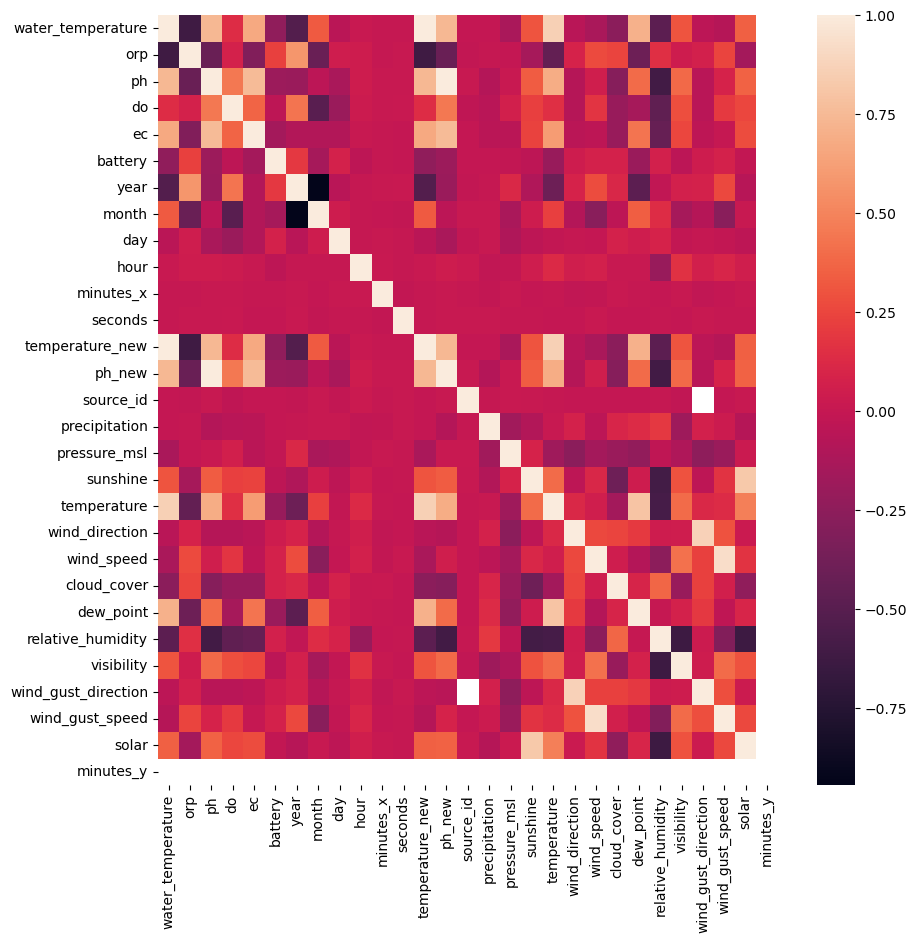

In [115]:
corr_mean=df_all.corr()
sns.heatmap(corr_mean)

## Feature Importance

In [116]:
weather_columns =[ 'precipitation', 'pressure_msl', 'sunshine',
       'temperature', 'wind_direction', 'wind_speed', 'cloud_cover',
       'dew_point', 'relative_humidity', 'visibility', 
       'wind_gust_speed',  'solar']

In [117]:
# Assign features (weather data) to X and target (water temperature) to y
X = df_all[weather_columns]
y = df_all['water_temperature']

# Split the data into training and testing sets
test_split_index = int(len(X) * 0.9)
# Split the data into training and testing sets
X_train = X.iloc[:test_split_index]
y_train = y.iloc[:test_split_index]
X_test = X.iloc[test_split_index:]
y_test = y.iloc[test_split_index:]

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training dataset
rf.fit(X_train, y_train)

# Get feature importances from the trained model
feature_importances = rf.feature_importances_

# Create a DataFrame for better visualization
importances_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})
importances_df = importances_df.sort_values(by='importance', ascending=False)

# Print the sorted feature importances
print(importances_df)

# Select the most important features based on a threshold or a specific number of features
selected_features = importances_df[importances_df['importance'] > 0.05]['feature'].values

              feature  importance
3         temperature    0.720537
7           dew_point    0.122522
4      wind_direction    0.039397
1        pressure_msl    0.035061
10    wind_gust_speed    0.018252
9          visibility    0.015331
6         cloud_cover    0.013560
5          wind_speed    0.012067
11              solar    0.009051
8   relative_humidity    0.008898
2            sunshine    0.003055
0       precipitation    0.002269


In [118]:
selected_features

array(['temperature', 'dew_point'], dtype=object)

In [119]:
def run_experiment(X_train, y_train, X_val, y_val, regressor, hyperparams: list):
    mse_all = []
    r2_all = []
    best_model = None
    best_r2 = -np.inf

    for hp in hyperparams:
        print("Hyperparameters:", hp)
        model = regressor(hp) if hp is not None else regressor()
        model.fit(X_train, y_train)
        pred = model.predict(X_val)
        
        mse = mean_squared_error(y_val, pred)
        r2 = r2_score(y_val, pred)
        mse_all.append(mse)
        r2_all.append(r2)
        
        if r2 > best_r2:
            best_model = model
            best_r2 = r2

        print("Validation MSE: %.3f" % mse)
        print("Validation R2 Score: %.3f" % r2)

    return best_model, mse_all, r2_all

## Random Forest

In [120]:
#Splitting the data
X = df_all[selected_features]
y = df_all['water_temperature']

val_split_index = int(len(X) * 0.8)
test_split_index = int(len(X) * 0.9)

X_train = X.iloc[:val_split_index]
y_train = y.iloc[:val_split_index]

X_val = X.iloc[val_split_index:test_split_index]
y_val = y.iloc[val_split_index:test_split_index]

X_test = X.iloc[test_split_index:]
y_test = y.iloc[test_split_index:]

In [121]:
rf_hyperparams = [10, 50, 100, 150, 200]
best_rf, mse_values_rf, r2_values_rf = run_experiment(X_train, y_train, X_val, y_val, RandomForestRegressor, rf_hyperparams)

Hyperparameters: 10
Validation MSE: 15.339
Validation R2 Score: -2.319
Hyperparameters: 50
Validation MSE: 14.489
Validation R2 Score: -2.135
Hyperparameters: 100
Validation MSE: 14.553
Validation R2 Score: -2.149
Hyperparameters: 150
Validation MSE: 14.736
Validation R2 Score: -2.189
Hyperparameters: 200
Validation MSE: 14.547
Validation R2 Score: -2.148


In [122]:
y_test_pred = best_rf.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.square(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print(f"Best RandomForestRegressor model: {best_rf}, n_estimators: {best_rf.n_estimators}")
print("Test MAE:", mae_test)
print("Test MSE:", mse_test)
print("Test RMSE:", rmse_test)
print("Test R2 Score:", r2_test)

Best RandomForestRegressor model: RandomForestRegressor(n_estimators=50), n_estimators: 50
Test MAE: 4.024112028743925
Test MSE: 21.54105410905662
Test RMSE: 464.0170121293051
Test R2 Score: -21.482984799806438


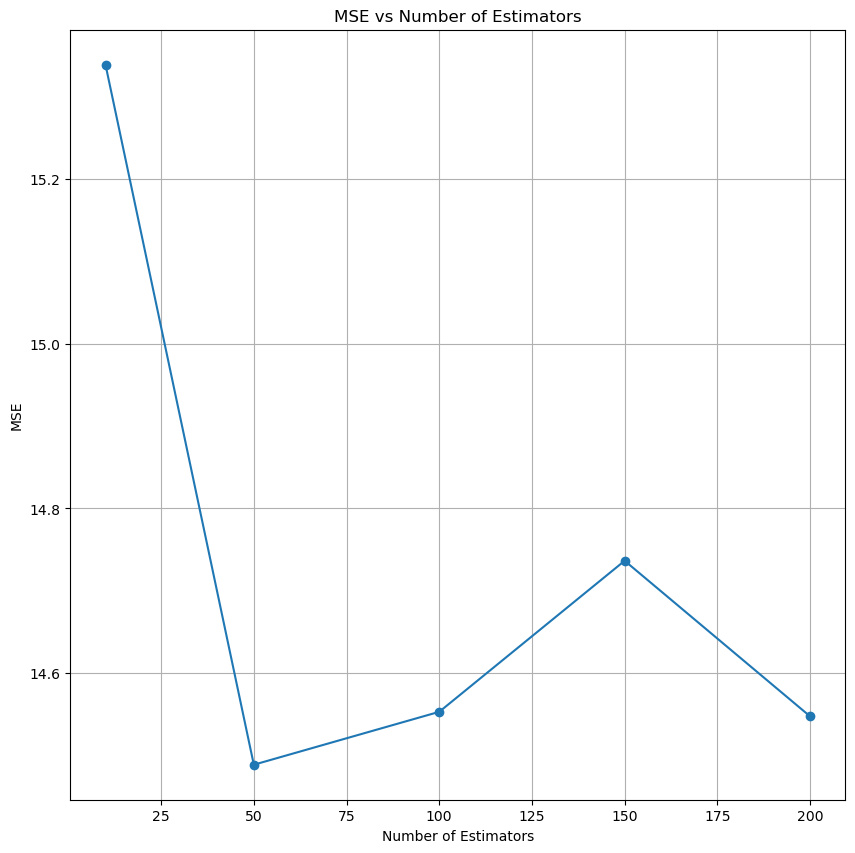

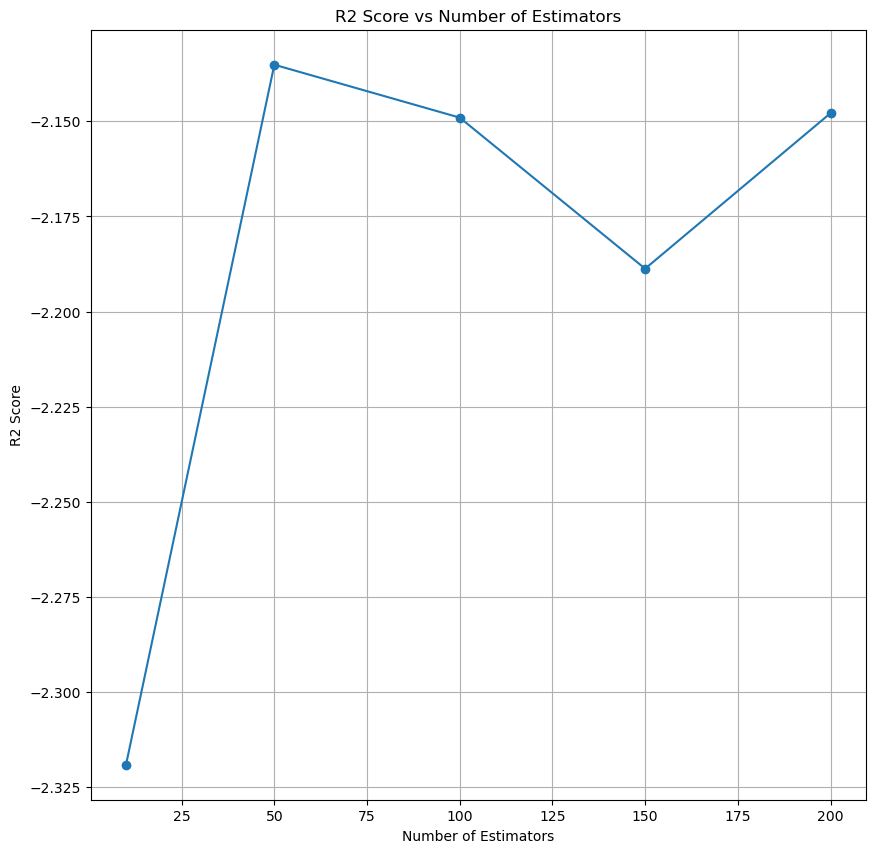

In [123]:
hyperparams = [10, 50, 100, 150, 200]
# Plot MSE values
plt.figure()
plt.plot(rf_hyperparams, mse_values_rf, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('MSE')
plt.title('MSE vs Number of Estimators')
plt.grid()
plt.show()

# Plot R2 values
plt.figure()
plt.plot(rf_hyperparams, r2_values_rf, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('R2 Score')
plt.title('R2 Score vs Number of Estimators')
plt.grid()
plt.show()

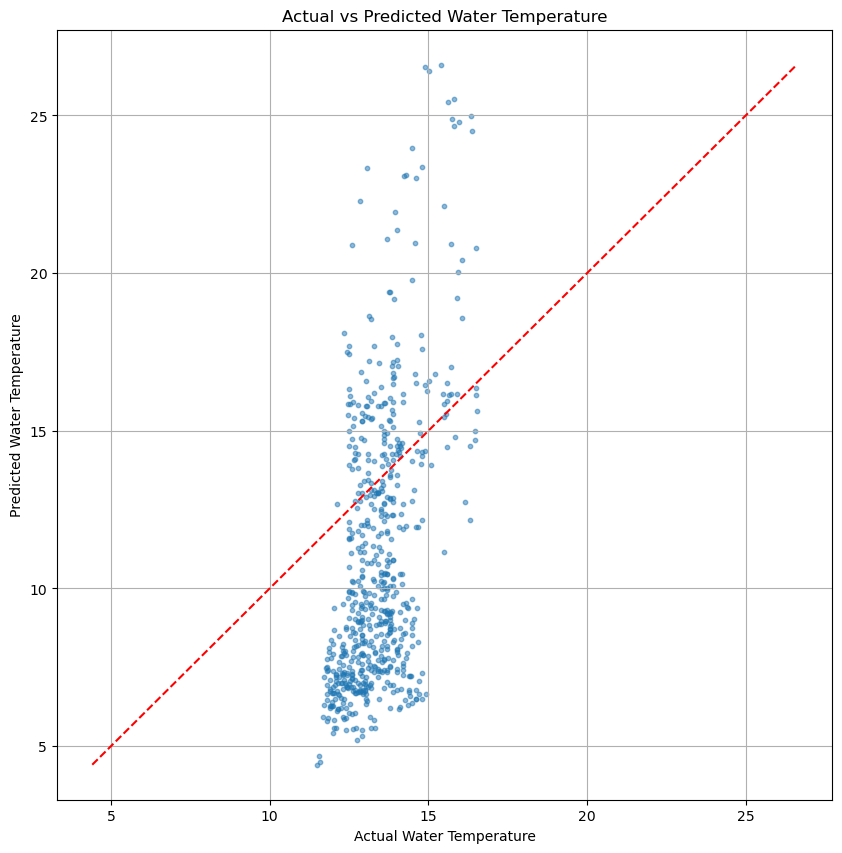

In [124]:
plt.figure()
plt.scatter(y_test, y_test_pred, alpha=0.5, s=10)
plt.xlabel('Actual Water Temperature')
plt.ylabel('Predicted Water Temperature')
plt.title('Actual vs Predicted Water Temperature')
plt.grid()

# Plot a diagonal line to visualize how well the predictions match the actual values
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.show()


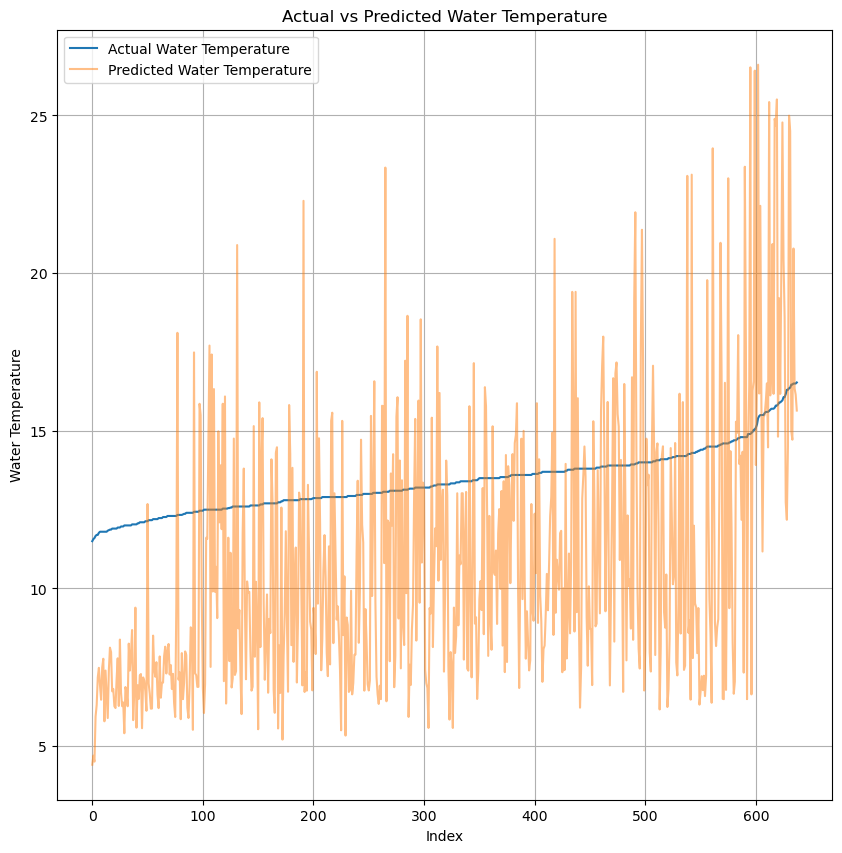

In [125]:
# Sort the test data and predictions by the actual water temperature values
sorted_indices = np.argsort(y_test)
y_test_sorted = y_test.iloc[sorted_indices].reset_index(drop=True)
y_test_pred_sorted = y_test_pred[sorted_indices]

# Create a line plot with actual and predicted values
plt.figure()
plt.plot(y_test_sorted, label='Actual Water Temperature')
plt.plot(y_test_pred_sorted, label='Predicted Water Temperature', alpha = 0.5)
plt.xlabel('Index')
plt.ylabel('Water Temperature')
plt.title('Actual vs Predicted Water Temperature')
plt.legend()
plt.grid()
plt.show()

## Linear Regression

In [128]:

def run_experiment(X_train, y_train, X_val, y_val, regressor, hyperparams=None):
    mse_all = []
    r2_all = []
    best_model = None
    best_r2 = -np.inf

    if regressor == LinearRegression:
        model = LinearRegression()
        model.fit(X_train, y_train)
        pred = model.predict(X_val)
        mse = mean_squared_error(y_val, pred)
        r2 = r2_score(y_val, pred)
        mse_all.append(mse)
        r2_all.append(r2)
        best_model = model
        best_r2 = r2
        print("Validation MSE: %.3f" % mse)
        print("Validation R2 Score: %.3f" % r2)
    else:
        for hp in hyperparams:
            print("Hyperparameters:", hp)
            model = regressor(**hp)
            model.fit(X_train, y_train)
            pred = model.predict(X_val)

            mse = mean_squared_error(y_val, pred)
            r2 = r2_score(y_val, pred)
            mse_all.append(mse)
            r2_all.append(r2)

            if r2 > best_r2:
                best_model = model
                best_r2 = r2

            print("Validation MSE: %.3f" % mse)
            print("Validation R2 Score: %.3f" % r2)

    return best_model, mse_all, r2_all


In [129]:
lr_hyperparams = {'fit_intercept': [True, False], 'normalize': [True, False]}
best_lr, mse_values_lr, r2_values_lr = run_experiment(X_train, y_train, X_val, y_val, LinearRegression, lr_hyperparams)

Validation MSE: 14.371
Validation R2 Score: -2.110


In [130]:
y_test_pred = best_lr.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mse_test = np.square(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print(f"Best Linear Refressuib model: {best_lr}")
print("Test MAE:", mae_test)
print("Test MSE:", mse_test)
print("Test RMSE:", rmse_test)
print("Test R2 Score:", r2_test)

Best Linear Refressuib model: LinearRegression()
Test MAE: 2.209983835301113
Test MSE: 61.56941147844715
Test RMSE: 464.0170121293051
Test R2 Score: -7.189728722833037


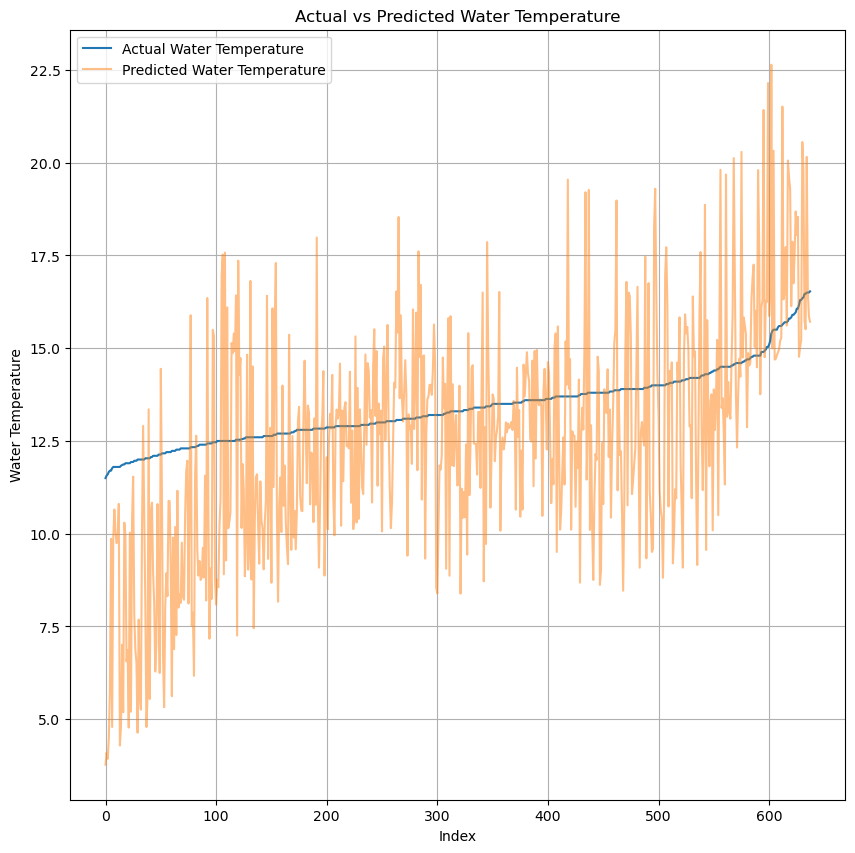

In [131]:
# Sort the test data and predictions by the actual water temperature values
sorted_indices = np.argsort(y_test)
y_test_sorted = y_test.iloc[sorted_indices].reset_index(drop=True)
y_test_pred_sorted = y_test_pred[sorted_indices]

# Create a line plot with actual and predicted values
plt.figure()
plt.plot(y_test_sorted, label='Actual Water Temperature')
plt.plot(y_test_pred_sorted, label='Predicted Water Temperature', alpha = 0.5)
plt.xlabel('Index')
plt.ylabel('Water Temperature')
plt.title('Actual vs Predicted Water Temperature')
plt.legend()
plt.grid()
plt.show()

## XGBoost

In [132]:
#Splitting the data
X = df_all[selected_features]
y = df_all['water_temperature']

# Split the data into train and test sets
train_size = int(len(df_all) * 0.8)
train_data, test_data = df_all.iloc[:train_size], df_all.iloc[train_size:]
# Define the features and target
X_train = train_data[selected_features]
y_train = train_data['water_temperature']
X_test = test_data[selected_features]
y_test = test_data['water_temperature']

In [133]:
def run_experiment_xgb(X_train, y_train, X_val, y_val, regressor, hyperparams: dict):
    mse_all = []
    r2_all = []
    best_model = None
    best_r2 = -np.inf
    # Generate all combinations of hyperparameters
    param_combinations = list(itertools.product(*hyperparams.values()))
    for params in param_combinations:
        print("Hyperparameters:", params)
        param_dict = {k: v for k, v in zip(hyperparams.keys(), params)}
        model = regressor(**param_dict)
        model.fit(X_train, y_train)
        pred = model.predict(X_val)

        mse = mean_squared_error(y_val, pred)
        r2 = r2_score(y_val, pred)
        mse_all.append(mse)
        r2_all.append(r2)

        if r2 > best_r2:
            best_model = model
            best_r2 = r2

        print("Validation MSE: %.3f" % mse)
        print("Validation R2 Score: %.3f" % r2)

    return best_model, mse_all, r2_all


In [134]:
hyperparams = {
    'max_depth': [2, 3, 4],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2]
}
best_model, mse_values, r2_values = run_experiment_xgb(X_train, y_train, X_val, y_val, XGBRegressor, hyperparams)

Hyperparameters: (2, 50, 0.05)
Validation MSE: 9.751
Validation R2 Score: -1.110
Hyperparameters: (2, 50, 0.1)
Validation MSE: 11.489
Validation R2 Score: -1.486
Hyperparameters: (2, 50, 0.2)
Validation MSE: 11.638
Validation R2 Score: -1.518
Hyperparameters: (2, 100, 0.05)
Validation MSE: 11.416
Validation R2 Score: -1.470
Hyperparameters: (2, 100, 0.1)
Validation MSE: 11.649
Validation R2 Score: -1.521
Hyperparameters: (2, 100, 0.2)
Validation MSE: 11.692
Validation R2 Score: -1.530
Hyperparameters: (2, 150, 0.05)
Validation MSE: 11.520
Validation R2 Score: -1.493
Hyperparameters: (2, 150, 0.1)
Validation MSE: 11.632
Validation R2 Score: -1.517
Hyperparameters: (2, 150, 0.2)
Validation MSE: 11.549
Validation R2 Score: -1.499
Hyperparameters: (3, 50, 0.05)
Validation MSE: 9.713
Validation R2 Score: -1.102
Hyperparameters: (3, 50, 0.1)
Validation MSE: 11.330
Validation R2 Score: -1.452
Hyperparameters: (3, 50, 0.2)
Validation MSE: 11.623
Validation R2 Score: -1.515
Hyperparameters: (3,

In [135]:
# Make predictions on the test dataset
y_pred = best_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.square(mse_test)
r2_test = r2_score(y_test, y_pred)

print(f"Best XBoost model: {best_model}, n_estimators: {best_model.n_estimators}")
print("Test MAE:", mae_test)
print("Test MSE:", mse_test)
print("Test RMSE:", rmse_test)
print("Test R2 Score:", r2_test)

Best XBoost model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...), n_estimators: 50
Test MAE: 3.336211121702506
Test MSE: 16.07697343353824
Test RMSE: 258.4690747826943
Test R2 Score: -1.1096815393448272


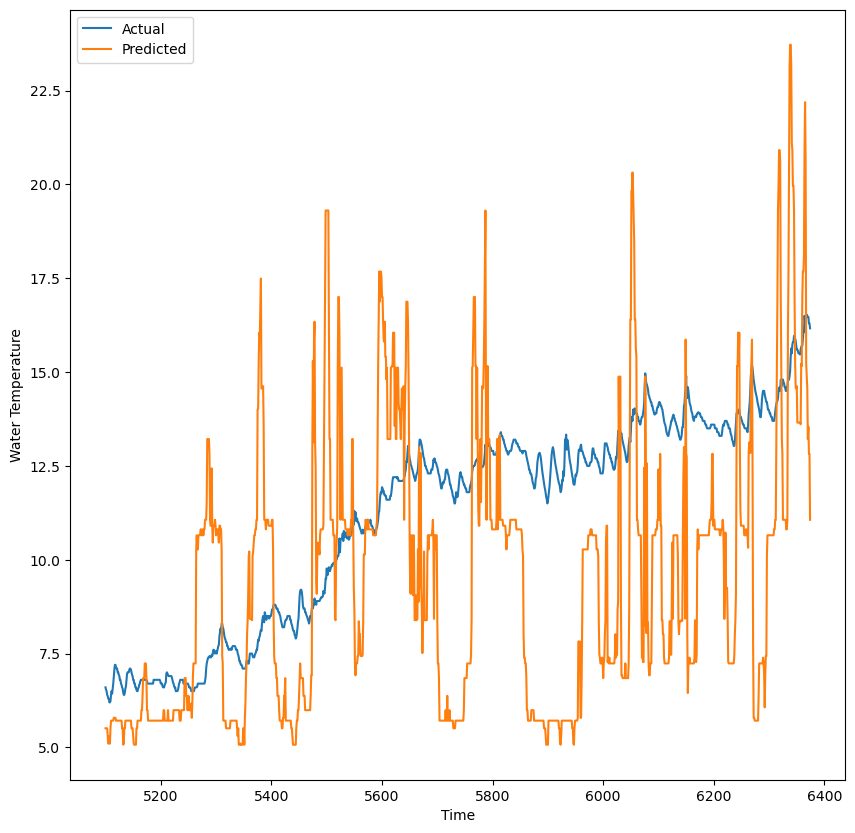

In [136]:
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Water Temperature')
plt.legend()
plt.show()

## XGBoost - only on the last 24 hours

In [137]:
#Splitting the data
X = df_all[selected_features]
y = df_all['water_temperature']

test_size = 24
validation_size = 24
train_size = len(df_all) - test_size - validation_size

# Define the features and target
X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + validation_size]
y_val = y[train_size:train_size + validation_size]

X_test = X[train_size + validation_size:]
y_test = y[train_size + validation_size:]


In [138]:
hyperparams = {
    'max_depth': [2, 3, 4],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2]
}

best_model, mse_values, r2_values = run_experiment_xgb(X_train, y_train, X_val, y_val, XGBRegressor, hyperparams)


Hyperparameters: (2, 50, 0.05)
Validation MSE: 20.475
Validation R2 Score: -67.911
Hyperparameters: (2, 50, 0.1)
Validation MSE: 27.258
Validation R2 Score: -90.739
Hyperparameters: (2, 50, 0.2)
Validation MSE: 27.959
Validation R2 Score: -93.098
Hyperparameters: (2, 100, 0.05)
Validation MSE: 27.536
Validation R2 Score: -91.675
Hyperparameters: (2, 100, 0.1)
Validation MSE: 27.993
Validation R2 Score: -93.214
Hyperparameters: (2, 100, 0.2)
Validation MSE: 28.284
Validation R2 Score: -94.193
Hyperparameters: (2, 150, 0.05)
Validation MSE: 28.195
Validation R2 Score: -93.892
Hyperparameters: (2, 150, 0.1)
Validation MSE: 27.945
Validation R2 Score: -93.051
Hyperparameters: (2, 150, 0.2)
Validation MSE: 29.019
Validation R2 Score: -96.666
Hyperparameters: (3, 50, 0.05)
Validation MSE: 20.449
Validation R2 Score: -67.822
Hyperparameters: (3, 50, 0.1)
Validation MSE: 28.035
Validation R2 Score: -93.354
Hyperparameters: (3, 50, 0.2)
Validation MSE: 29.873
Validation R2 Score: -99.542
Hyperp

In [139]:
# Make predictions on the test dataset
y_pred = best_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
mse_test = np.square(mse_test)
r2_test = r2_score(y_test, y_pred)

print("Test MAE:", mae_test)
print("Test MSE:", mse_test)
print("Test RMSE:", rmse_test)
print("Test R2 Score:", r2_test)

Test MAE: 2.687041446897719
Test MSE: 81.04478390527125
Test RMSE: 258.4690747826943
Test R2 Score: -56.10427372334526


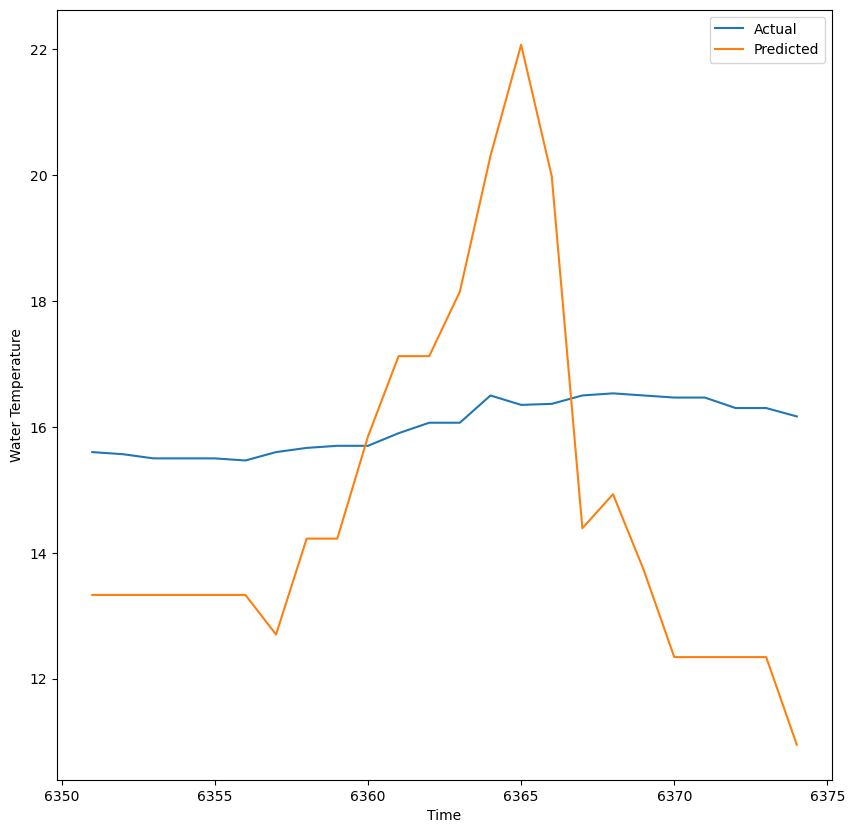

In [140]:
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Water Temperature')
plt.legend()
plt.show()

## Prophet

In [141]:
subset_prophet = df_under_study[['temperature']].reset_index()
subset_prophet.columns = ['ds', 'y']
subset_prophet

val_split_index = int(len(df_under_study) * 0.8)
test_split_index = int(len(df_under_study) * 0.9)

y_train = subset_prophet.iloc[:val_split_index]
y_val = subset_prophet.iloc[val_split_index:test_split_index]
y_test = subset_prophet.iloc[test_split_index:]

In [142]:
def optimize_prophet(train_data, validation_data, seasonality_params, seasonality_mode_params, changepoint_prior_scale_params, fourier_order_params):
    best_mse = float("inf")
    best_params = None
    
    param_grid = list(itertools.product(seasonality_params, seasonality_mode_params, changepoint_prior_scale_params, fourier_order_params))
    
    for params in param_grid:
        seasonality, seasonality_mode, changepoint_prior_scale, fourier_order = params
       
        model = Prophet(seasonality_mode=seasonality_mode, changepoint_prior_scale=changepoint_prior_scale)
        model.add_seasonality(name='custom', period=seasonality, fourier_order=fourier_order)
        
        model.fit(train_data)
        
        future = model.make_future_dataframe(periods=len(validation_data), freq='D')
        forecast = model.predict(future)
     
        predicted_values = forecast.loc[len(train_data):, 'yhat'].reset_index(drop=True)
        mse = mean_squared_error(validation_data['y'], predicted_values)

        if mse < best_mse:
            best_mse = mse
            best_params = params
            
    return best_params, best_mse

In [143]:
seasonality_params = [30, 7, 1]  
seasonality_mode_params = ['additive', 'multiplicative']
changepoint_prior_scale_params = [0.01, 0.1, 1]
fourier_order_params = [2, 3, 4]

best_params, best_mse = optimize_prophet(y_train, y_val, seasonality_params, seasonality_mode_params, changepoint_prior_scale_params,fourier_order_params )

print(f"Best Parameters: {best_params}")
print(f"Best MSE: {best_mse}")

23:08:33 - cmdstanpy - INFO - Chain [1] start processing
23:08:35 - cmdstanpy - INFO - Chain [1] done processing
23:08:37 - cmdstanpy - INFO - Chain [1] start processing
23:08:38 - cmdstanpy - INFO - Chain [1] done processing
23:08:40 - cmdstanpy - INFO - Chain [1] start processing
23:08:41 - cmdstanpy - INFO - Chain [1] done processing
23:08:43 - cmdstanpy - INFO - Chain [1] start processing
23:08:45 - cmdstanpy - INFO - Chain [1] done processing
23:08:47 - cmdstanpy - INFO - Chain [1] start processing
23:08:49 - cmdstanpy - INFO - Chain [1] done processing
23:08:50 - cmdstanpy - INFO - Chain [1] start processing
23:08:52 - cmdstanpy - INFO - Chain [1] done processing
23:08:54 - cmdstanpy - INFO - Chain [1] start processing
23:08:57 - cmdstanpy - INFO - Chain [1] done processing
23:08:58 - cmdstanpy - INFO - Chain [1] start processing
23:09:02 - cmdstanpy - INFO - Chain [1] done processing
23:09:04 - cmdstanpy - INFO - Chain [1] start processing
23:09:06 - cmdstanpy - INFO - Chain [1]

Best Parameters: (7, 'additive', 0.01, 2)
Best MSE: 300.4634440347017


In [144]:
seasonality, seasonality_mode, changepoint_prior_scale, fourier_order = best_params

best_model = Prophet(seasonality_mode=seasonality_mode, changepoint_prior_scale=changepoint_prior_scale)
best_model.add_seasonality(name='custom', period=seasonality, fourier_order=fourier_order)

train_validation_data = pd.concat([y_train, y_val], axis=0)
best_model.fit(train_validation_data)

future = best_model.make_future_dataframe(periods=len(y_test), freq='D')
forecast = best_model.predict(future)

23:11:43 - cmdstanpy - INFO - Chain [1] start processing
23:11:45 - cmdstanpy - INFO - Chain [1] done processing


In [145]:
val_predictions = forecast.loc[len(y_train):(len(y_train) + len(y_val) - 1), 'yhat']
val_true_values = y_val['y']

# Calculate evaluation metrics for the validation set
mae_val = mean_absolute_error(val_true_values, val_predictions)
mse_val = mean_squared_error(val_true_values, val_predictions)
rmse_val = np.sqrt(mse_val)

print(f"Validation MAE: {mae_val}")
print(f"Validation MSE: {mse_val}")
print(f"Validation RMSE: {rmse_val}")

# Extract predictions for the test set
test_predictions = forecast.loc[(len(y_train) + len(y_val)):, 'yhat'].reset_index(drop=True)
test_true_values = y_test['y']

Validation MAE: 1.3210113906567107
Validation MSE: 1.9700920772355834
Validation RMSE: 1.4035996855355815


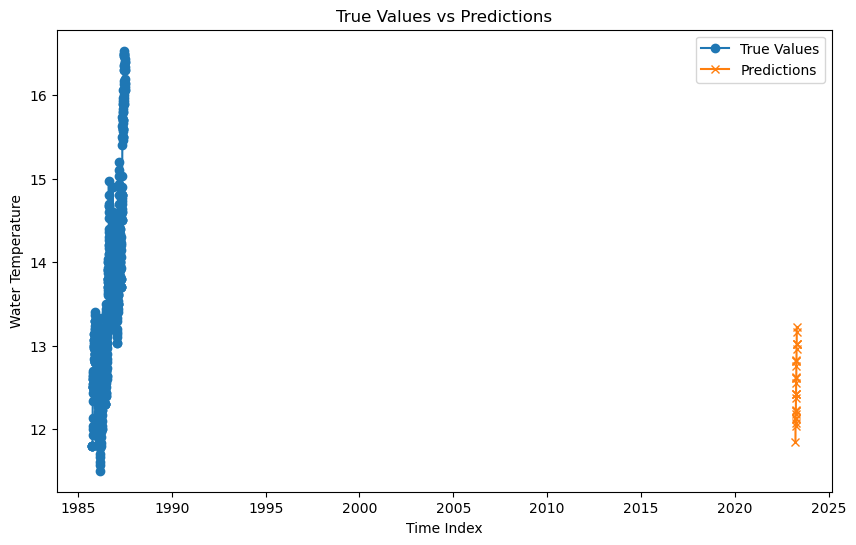

In [146]:
plt.figure(figsize=(10, 6))
plt.plot(test_true_values, label='True Values', linestyle='-', marker='o')
plt.plot(predictions, label='Predictions', linestyle='-', marker='x')
plt.legend()
plt.xlabel('Time Index')
plt.ylabel('Water Temperature')
plt.title('True Values vs Predictions')
plt.show()